In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib
from operator import itemgetter, attrgetter
import pandas as pd
import seaborn as sn
import math
import scipy.spatial as spatial
import scipy.stats as stats
import numpy as np
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import functools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import random

# Own Scripts
import data_loading as dl
import data_loading.analysis_file_loader
import data_loading.algo_performance_file_loader
import data_loading.ovi_iters_file_loader
from data_loading.file_loader_utils import is_float, is_property_defined
from data_loading.data_entities.data_union import DataUnionFileInputObject, DataUnion

In [2]:
#Constants
ALL_PATHS = [
    '../sashas-scripts/manyAct_steps/',
    '../sasha-tacas-scripts/tacasRealModels/',
    '../sasha-tacas-scripts/tacasRealModels_4/',
    '../sasha-tacas-scripts/tacasRandomConnected/',
    '../sasha-tacas-scripts/oviGood/',
    '../sasha-tacas-scripts/oviBad/',
    '../sasha-tacas-scripts/tacasRealModels_2/',
    '../sasha-tacas-scripts/tacasHandcraftedModels/',
    '../sasha-tacas-scripts/tacasRandomConnected15Min/',
    '../sasha-tacas-scripts/tacasRandomTree15Min/',    
    '../thesis-scripts/bigMECConfModelsNoPre/',
    '../thesis-scripts/randomRandomModelsDistribution/',
    '../thesis-scripts/randomRandomModelsDistribution2/',
    '../thesis-scripts/randomSCC/',
    '../thesis-scripts/realModels/',
    '../thesis-scripts/realModels_2/',
    '../thesis-scripts/handcraftedModels/',
    '../thesis-scripts/randomRandomThesis/',   
    '../thesis-scripts/randomRandom/',
    '../thesis-scripts/randomRandom10Act/',
    '../thesis-scripts/randomSCCFixed/',
    '../thesis-scripts/randomSCCFixed_2/',
    '../thesis-scripts/oneBigSccNoMEC/',
    '../thesis-scripts/midConfModels/',
    '../thesis-scripts/midConfModels2/',
    '../thesis-scripts/oviEdgecase/',
    '../thesis-scripts/WPBetterThanOVI/',
    '../thesis-scripts/randomBigSCC/',
    
    
    
]

THESIS_PATHS = [
    '../thesis-scripts/realModels/',
    '../thesis-scripts/handcraftedModels/',
    '../thesis-scripts/randomRandomThesis/',
    '../thesis-scripts/randomRandom10Act/',
    '../thesis-scripts/randomSCCFixed_2/',
    
    
    '../thesis-scripts/bigRealModels/',
    '../thesis-scripts/bigRealModelsNoPrecomp/',
    '../thesis-scripts/bigConfModels/',
    '../thesis-scripts/bigConfModelsNoPre/',
    
    
]

CAV_PATHS = [
    '../thesis-scripts/realModels/',
    '../thesis-scripts/handcraftedModels/',
    '../thesis-scripts/randomRandom10Act/',
    '../thesis-scripts/bigConfModels/',
    #'../sasha-tacas-scripts/oviGood/',
]

LOAD_PATHS = [
    '../thesis-scripts/realModels_2/',
    '../thesis-scripts/realModels/',
    '../thesis-scripts/handcraftedModels/',
    '../thesis-scripts/randomRandomThesis/',
    '../thesis-scripts/randomRandom10Act/',
    '../thesis-scripts/randomSCCFixed_2/',
    #'../thesis-scripts/randomBigSCC/',
    #'../thesis-scripts/midConfModels2/',
    #'../thesis-scripts/bigRealModels/',
    '../thesis-scripts/bigConfModels/',
]

#LOAD_PATHS = CAV_PATHS

## Load Data

#### Load Analysis Data

In [3]:
property_meta_keys = ["Model"]

property_keys = [
    "NumStates",
    "NumActions",
    "NumTargets",
    "NumSinks",
    "NumUnknown",
    "NumMaxActions",
    "NumMaxTransitions",
    "SmallestTransProb",
    "NumProbActions",
    "NumMECs",
    "BiggestMEC",
    "SmallestMEC",
    "AvgMEC",
    "MedianMEC",
    "NumSCCs",
    "BiggestSCC",
    "AvgSCC",
    "NearestTarget",
    "FurthestTarget",
    "AvgNumActionsPerState",
    #"AvgNumTransPerState",
    "AvgNumTransPerAction",
    "NumMaxStates",
    "NumMinStates",
    "NumBackwardsTransitions",
    "MaxSCCDepth",
    "NumNonSingleton",
    "SmallestSCCNonSing",
    "AvgSccNonSing",
]

time_comp_props = [
    "Prob0InSec",
    "Prob1InSec",
    "MECCompInSec",
    "SCCCompInSec"
]

simple_props = ["NumStates"]

#property_keys = property_keys + time_comp_props
#property_keys = simple_props

analysis_keys = property_meta_keys + property_keys

In [4]:
# Load the data from the analysis.csv-files

analysis_csv_file_paths = list(map(lambda path : path+"analysis.csv",LOAD_PATHS))

# Provide a function for filtering

def analysis_csv_filter_function(row_to_include, filter_dict):
    relevant_keys = row_to_include.keys()
    unknown_threshold = 0
    
    if ("Timeout" not in filter_dict):
        filter_dict["Timeout"] = 0
    if ("Unknown<=%d" % unknown_threshold not in filter_dict):
        filter_dict["Unknown<=%d" % unknown_threshold] = 0
    if ("SpecialFilters" not in filter_dict):
        filter_dict["SpecialFilters"] = 0
    
    GENERAL_FILTERS = True
    if GENERAL_FILTERS:
            if not is_property_defined("NumStates", relevant_keys,
                                        row_to_include):
                    if "Timeout" in filter_dict:
                        filter_dict["Timeout"] +=1
                    #print("Noone has solved Model %s" % row["Model"])
                    return False
            elif (is_property_defined("NumUnknown", relevant_keys, row_to_include) and
                    int(row_to_include["NumUnknown"]) <= unknown_threshold):
                    filter_dict["Unknown<=%d" % unknown_threshold] +=1
                    #print("Model %s has less than %d unknown states --> too easy " % (row["Model"], unknown_threshold))
                    return False

    #Special Filtering Criteria for different test-suites
    SPECIAL_FILTERS = True
    if (SPECIAL_FILTERS):
        filter_conditions = [
            "simple" == row_to_include["Model"],
            "hm_25" in row_to_include["Model"],
            #"simple_1000000_10_SCC" in row_to_include["Model"],
            #"simple_5000000_1_SCC" in row_to_include["Model"],
            #"simple_4000000_1_SCC" in row_to_include["Model"],
            #float(row_to_include["BiggestSCC"]) == 0
        ]

        if (True in filter_conditions):
            filter_dict["SpecialFilters"]+=1
            return False


    return True

# Load the data
print(data_loading)

analysis_file_data = dl.analysis_file_loader.load_file(
    analysis_keys, 
    analysis_csv_file_paths,
    primary_key_name = "Model",
    filter_function = analysis_csv_filter_function
)

# Normalize the data
for i in range(len(analysis_file_data.data['Model'])):
    num_states = float(analysis_file_data.data["NumStates"][i])
    # Normalize state related properties
    for value_to_normalize in [
            "NumTargets",
            "NumSinks",
            "NumUnknown",
            "NumMaxStates",
            "NumMinStates",
        
            "BiggestSCC",
            "AvgSCC",
            #"SmallestSCCNonSing",
            "AvgSccNonSing",
        
            "BiggestMEC",
            "AvgMEC",
        
        ]:
        if (value_to_normalize in analysis_keys and num_states != 0):
            value = analysis_file_data.data[value_to_normalize][i]
            analysis_file_data.data[value_to_normalize][i] = float(value) / num_states
        if (value_to_normalize not in analysis_keys):
            print(f'{value_to_normalize} does not appear in the property keys')
    
    # Normalize action related properties
    num_actions = float(analysis_file_data.data["NumActions"][i])
    for value_to_normalize in [
        "NumProbActions"
    ]:
        if (value_to_normalize in analysis_keys and num_actions != 0):
            value = analysis_file_data.data[value_to_normalize][i]
            analysis_file_data.data[value_to_normalize][i] = float(value) / num_actions

<module 'data_loading' from '/home/sascha/Algorithms-For-Stochastic-Games/visualizations/data_loading/__init__.py'>
18 / 26 Model from Path ../thesis-scripts/realModels_2/analysis.csv remain after filtering
Reasons for filtering:
	Timeout: 0
	Unknown<=0: 8
	SpecialFilters: 0
18 / 26 Model from Path ../thesis-scripts/realModels/analysis.csv remain after filtering
Reasons for filtering:
	Timeout: 0
	Unknown<=0: 8
	SpecialFilters: 0
10 / 11 Model from Path ../thesis-scripts/handcraftedModels/analysis.csv remain after filtering
Reasons for filtering:
	Timeout: 0
	Unknown<=0: 0
	SpecialFilters: 1
88 / 100 Model from Path ../thesis-scripts/randomRandomThesis/analysis.csv remain after filtering
Reasons for filtering:
	Timeout: 0
	Unknown<=0: 12
	SpecialFilters: 0
100 / 100 Model from Path ../thesis-scripts/randomRandom10Act/analysis.csv remain after filtering
Reasons for filtering:
	Timeout: 0
	Unknown<=0: 0
	SpecialFilters: 0
100 / 100 Model from Path ../thesis-scripts/randomSCCFixed_2/analy

#### Load Algorithm Data

In [5]:
metaKeys = ["Model"]

tacas_keys = [
    "BVI",
    "D_BVI",
    "D_SVI",
    #"DG_BVI",
    #"DG_SVI",
    "G_BVI",
    "G_OVI",
    "G_SVI",
    "OPT_OVI",
    "OVI",
    "WP_OVI",
    "SVI",
    "TOP_BVI",
    "TOP_OVI",
    "TOP_SVI",
    "TOP_VI",
    "T_BVI",
    "T_OVI",
    #"T_SVI",
    "VI",
    "WP",
    "WP_P3",
    "WP_OII",
    "D_WP_OII"
]

thesis_configs = [
    #BVI
    "BVI",
    "D_BVI",
    "G_BVI",
    "TOP_BVI",
    "T_BVI",
    
    #OVI
    "G_OVI",
    "OVI",
    #"TOP_OVI",
    "T_OVI",

    #VI
    #"TOP_VI",
    "VI",

    #WP
    "WP_P3",
    
    #SI
    "SI",
    "SI_SI",
    #"T_SI_SI",
    "LP_SI",
    "T_LP_SI"
]


prototype = ["BVI", "WP_P3"]

cav = ["WP_P3", "T_LP_SI", "VI", "OVI", "BVI", "TOP_BVI"]
cav_without_vi = ["WP_P3", "T_LP_SI", "OVI", "BVI", "TOP_BVI"]

top = ["T_LP_SI", "TOP_BVI", "WP_P3", "BVI"]
ovi = ["OVI", "T_OVI"]
cav_extend = cav + ["T_BVI", "D_BVI", "G_BVI", "G_OVI", "LP_SI"]
top_bvi = ["TOP_BVI", "BVI"]

big_models = ["TOP_BVI", "T_LP_SI", "T_SI_SI", "WP_P3"]

config_keys = thesis_configs
#config_keys = prototype
#config_keys = need
#config_keys = ovi
#config_keys = top
config_keys = cav_without_vi+["LP_SI", "SI_SI", "SI"]
#config_keys = big_models
#config_keys = cav_extend
#config_keys = top


relevantKeys = metaKeys + config_keys
relevantKeys

['Model', 'WP_P3', 'T_LP_SI', 'OVI', 'BVI', 'TOP_BVI', 'LP_SI', 'SI_SI', 'SI']

In [6]:
# Make sure no key is added twice - this would lead to errors
if len(relevantKeys) > len(set(relevantKeys)):
    print(f'Len: {len(relevantKeys)}, SetLen: {len(set(relevantKeys))}')
    raise Exception(f'Every key MUST be Unique in relevantKeys!!')

In [7]:
# Load the data from the time, value and iters csv files
GET_OVI_ITERS = False

time_csv_file_paths = list(map(lambda path : path+"times.csv",LOAD_PATHS))
values_csv_file_paths = list(map(lambda path : path+"values.csv",LOAD_PATHS))
iters_csv_file_paths = list(map(lambda path : path+"iters.csv",LOAD_PATHS))
ovi_iters_csv_file_paths = list(map(lambda path : path+"ovi_iters.csv",LOAD_PATHS))


values_file_data = dl.algo_performance_file_loader.load_file(
    relevantKeys,
    values_csv_file_paths,
    primary_key_name = "Model",
    filter_function = None
)
iters_file_data = dl.algo_performance_file_loader.load_file(
    relevantKeys,
    iters_csv_file_paths,
    primary_key_name = "Model",
    filter_function = None
)
time_file_data = dl.algo_performance_file_loader.load_file(
    relevantKeys,
    time_csv_file_paths,
    primary_key_name = "Model",
    filter_function = None
)
ovi_iters_file_data = None
if (GET_OVI_ITERS):
    ovi_iters_file_data = dl.ovi_iters_file_loader.load_file(
        ["Conf","Model","Verification Time","Number Of Verif. Phases","Iterations in Verif Phase","NumAborted",
         "NumInduceLowerBound","NumFailedVerif"],
        ovi_iters_csv_file_paths,
        primary_key_name = "Model",
        filter_function = None

    )

26 / 26 Model from Path ../thesis-scripts/realModels_2/values.csv remain after filtering
26 / 26 Model from Path ../thesis-scripts/realModels/values.csv remain after filtering
11 / 11 Model from Path ../thesis-scripts/handcraftedModels/values.csv remain after filtering
100 / 100 Model from Path ../thesis-scripts/randomRandomThesis/values.csv remain after filtering
100 / 100 Model from Path ../thesis-scripts/randomRandom10Act/values.csv remain after filtering
100 / 100 Model from Path ../thesis-scripts/randomSCCFixed_2/values.csv remain after filtering
19 / 19 Model from Path ../thesis-scripts/bigConfModels/values.csv remain after filtering
26 / 26 Model from Path ../thesis-scripts/realModels_2/iters.csv remain after filtering
26 / 26 Model from Path ../thesis-scripts/realModels/iters.csv remain after filtering
11 / 11 Model from Path ../thesis-scripts/handcraftedModels/iters.csv remain after filtering
100 / 100 Model from Path ../thesis-scripts/randomRandomThesis/iters.csv remain after

#### Check for Errors

In [8]:
SEARCH_ERRORS = True
if (SEARCH_ERRORS):
    for path in LOAD_PATHS:
        for conf in config_keys:
            conf_path = path+conf+"/"
            for model_file_name in os.listdir(conf_path):
                with open(conf_path+model_file_name, newline='\n') as conf_model_run:
                    for line in conf_model_run:
                        if ("Exception" in line or "Error" in line):
                            print("IN CONF %s AND FILE \n%s: " % (conf, model_file_name))
                            print(line)

IN CONF TOP_BVI AND FILE 
AV15_15_3.log: 
Error: If Minimizer has free choice then state 1 gets value 0.1 but if Maximizer has free choice states gets value 1.0 ==> Topological value iteration failed.

IN CONF TOP_BVI AND FILE 
AV10_10_3.log: 
Error: If Minimizer has free choice then state 1 gets value 0.1 but if Maximizer has free choice states gets value 1.0000000000004547 ==> Topological value iteration failed.

IN CONF TOP_BVI AND FILE 
AV15_15_3.log: 
Error: If Minimizer has free choice then state 1 gets value 0.1 but if Maximizer has free choice states gets value 1.0 ==> Topological value iteration failed.

IN CONF TOP_BVI AND FILE 
AV10_10_3.log: 
Error: If Minimizer has free choice then state 1 gets value 0.1 but if Maximizer has free choice states gets value 1.0000000000004547 ==> Topological value iteration failed.

IN CONF SI_SI AND FILE 
BigMec_1e4.errors.log: 
Exception in thread "main" java.lang.OutOfMemoryError: Java heap space

IN CONF TOP_BVI AND FILE 
RANDOM_Size_1000

In [10]:
# Compare Value Data and set incorrectly computed to -1
REF_CONF = "WP_P3"

if (values_file_data != None):
    value_data = values_file_data.data
    wrong_values = dict()
    number_of_computed_models = dict()
    number_of_models_compared = len(list(filter(lambda x : x != -1, value_data[REF_CONF])))
    
    # Initialize dict that stores wrong values
    for key in value_data.keys():
            wrong_values[key] = 0
            number_of_computed_models[key] = len(list(filter(lambda x : x != -1, value_data[key])))
    
    for key in value_data.keys():
        if (key == "Model" or key == "#States" or key == REF_CONF):
            continue
        
        for i in range(len(value_data[REF_CONF])):
            if (value_data[REF_CONF][i] == -1):
                #print(f'For {value_data["Model"][i]} algorithm {REF_CONF} has no solution and thus cannot be used as a reference')
                continue

            if (value_data[key][i] == -1):
                #print(f'For {value_data["Model"][i]} algorithm {key} has no solution.')
                #number_of_computed_models[key]-=1
                continue
                
            if (abs(float(value_data[REF_CONF][i]) - float(value_data[key][i])) > 1e-6):
                print(f'Wrong Value in {key} for model {value_data["Model"][i]}:')
                print(f'Ref : {value_data[REF_CONF][i]}')
                print(f'Conf: {value_data[key][i]}')
                wrong_values[key]+=1
                
                # Mark as incorrectly computed
                time_file_data.data[key][i] = -1
                iters_file_data.data[key][i] = -1
                
    for key in wrong_values.keys():
        if (wrong_values[key] == 0 and number_of_computed_models[key] != 0):
            continue
        
        print(f'Algo {key} has a wrong result in {wrong_values[key]}/{number_of_computed_models[key]} compared models ')

Wrong Value in SI_SI for model simple_3000000_5_SCC:
Ref : 0.12518723119769742
Conf: 0.0
Wrong Value in SI for model simple_100000_5_SCC:
Ref : 0.11631663331683709
Conf: 0.11631788710225033
Wrong Value in SI for model ManyMECs_1e2:
Ref : 0.49999902089669956
Conf: 0.49999764823429166
Wrong Value in SI for model ManyMECs_1e3:
Ref : 0.4999990646800019
Conf: 0.49999276955159316
Wrong Value in SI for model hm_10:
Ref : 0.49999906723879284
Conf: 0.4996198267673878
Wrong Value in SI for model hm_20:
Ref : 0.49999906671517214
Conf: 0.27988957314510005
Wrong Value in SI for model hm_5:
Ref : 0.49999907227085105
Conf: 0.49999000504011987
Algo SI_SI has a wrong result in 1/183 compared models 
Algo SI has a wrong result in 6/283 compared models 


#### Load Config Data

In [11]:
#Filtering Options

def should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved):
    return False
    #return at_least_one_has_not_solved
    #return not at_least_one_has_solved

In [12]:
def modelIncludedInProperties(model_name, table_properties):
    for row in table_properties:
        if row["Model"] == model_name:
            return True
    return False

### Unify Data

In [13]:
# Prepare Unification
analysis_input = DataUnionFileInputObject(
    file_data_object=analysis_file_data,
    file_data_prefix=''
)

In [14]:
# Remove '#States' from values, iters and time
for data in [
    values_file_data.data,
    iters_file_data.data,
    time_file_data.data,
]:
    if '#States' in data.keys():
        data.pop('#States')

iters_prefix = 'iters_'
times_prefix = ''
        
values_input = DataUnionFileInputObject(
    file_data_object=values_file_data,
    file_data_prefix='values_'
)
iters_input = DataUnionFileInputObject(
    file_data_object=iters_file_data,
    file_data_prefix=iters_prefix
)
time_input = DataUnionFileInputObject(
    file_data_object=time_file_data,
    file_data_prefix=times_prefix
)
ovi_iters_input = DataUnionFileInputObject(
    file_data_object=ovi_iters_file_data,
    file_data_prefix='ovi_iters'
)

In [15]:
# Unify Data
input_list = [
        analysis_input,
        time_input,
        values_input,
        iters_input,
]
if (GET_OVI_ITERS):
    input_list.append(ovi_iters_input)

unified_data = DataUnion(input_list)
model_names = unified_data.primary_key_values

# Replacement values
analysis_replacement_value = 0
ITERS_PENALTY = 1_000_000
TIME_PENALTY = 60 * 15

unified_data.replace_values_for_input_object(analysis_input, -1, analysis_replacement_value)
unified_data.replace_values_for_input_object(iters_input, -1, ITERS_PENALTY)
unified_data.replace_values_for_input_object(time_input, -1, TIME_PENALTY)
if (GET_OVI_ITERS):
    unified_data.replace_values_for_input_object(ovi_iters_input, -100, 3)


data = unified_data.data
PENTALY_FOR_NOT_FINISHING = TIME_PENALTY
USE_TIMES = times_prefix == ''
USE_ITERS = iters_prefix == ''
if (USE_ITERS):
    PENTALY_FOR_NOT_FINISHING = ITERS_PENALTY

In [16]:
def indexOfModelName(name):
    for i in range(len(model_names)):
        if (model_names[i] == name):
            return i
    return -1

In [17]:
label_mapping = dict()
label_reverse_mapping = dict()

for conf in config_keys:
    label_reverse_mapping[conf] = conf
    label_mapping[conf] = conf

# CAV Mapping

label_mapping["SI"] = 'SI_VI'
label_mapping["WP_P3"] = 'WP'
label_mapping["BVI"] = 'BVI'
label_mapping["OVI"] = 'OVI'
label_mapping["VI"] = 'VI'
label_mapping["LP_SI"] = 'SI_LP'
label_mapping["SI_SI"] = 'SI_SI'


label_mapping["T_BVI"] = 'TBVI'
label_mapping["T_OVI"] = 'TOVI'
label_mapping["T_LP_SI"] = 'SI'#'TSI_LP'
label_mapping["T_SI_SI"] = 'TSI_SI'
label_mapping["G_OVI"] = 'GOVI'
label_mapping["G_BVI"] = 'GBVI'
label_mapping["D_BVI"] = 'DBVI'
label_mapping["TOP_BVI"] = 'PTBVI'



# Latex Mapping

label_mapping["SI"] = r'$\mathrm{SI_{VI}}$'
label_mapping["WP_P3"] = r'$\mathrm{WP}$'
label_mapping["BVI"] = r'$\mathrm{BVI}$'
label_mapping["OVI"] = r'$\mathrm{OVI}$'
label_mapping["VI"] = r'$\mathrm{VI}$'
label_mapping["LP_SI"] = r'$\mathrm{SI_{LP}}$'
label_mapping["SI_SI"] = r'$\mathrm{SI_{SI}}$'


label_mapping["T_BVI"] = r'$\mathrm{BVI^T}$'
label_mapping["T_OVI"] = r'$\mathrm{OVI^T}$'
label_mapping["T_LP_SI"] = r'$\mathrm{SI_{LP}^T}$'
label_mapping["T_SI_SI"] = r'$\mathrm{SI_{SI}^T}$'
label_mapping["G_OVI"] = r'$\mathrm{OVI^G}$'
label_mapping["G_BVI"] = r'$\mathrm{BVI^G}$'
label_mapping["D_BVI"] = r'$\mathrm{BVI^D}$'
label_mapping["TOP_BVI"] = r'$\mathrm{BVI^{PT}}$'



for conf in config_keys:
    label_reverse_mapping[label_mapping[conf]] = conf

print(label_mapping["T_LP_SI"])

$\mathrm{SI_{LP}^T}$


### Attach labels if you want to

In [18]:
#print(model_names)
#print(data["Number Of Verif. Phases"])
#print(data["WP"])

In [19]:
USE_LABELS = False
if (USE_LABELS):
    model_name_labels = [
        "MinAct_2", #Default Label
        "MinAct_5",
        "MinAct_10",
    ]
    labeling = []

    counter = 0
    for model in model_names:
        for label in model_name_labels:
            if (label in model):
                labeling.append(label)
                break
        counter+=1
        if (counter > len(labeling)):
            labeling.append(model_name_labels[0])

    color_options = [
        "blue",
        "red",
        "green",
        "cyan"
    ]
    
    pandas_labels = pd.Series(labeling)

    coloring = dict()
    for i in range(len(model_name_labels)):
        coloring[model_name_labels[i]] = color_options[i]

    print(coloring)

In [20]:
def findModelWithNameInTable(table, modelName):
    for row in table:
        if row["Model"] == modelName:
            return row

In [21]:
## Load Matplotlib fonts
# PyPlot settings Settings
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "normal",
    #"font.sans-serif": ["Helvetica"],
    "font.weight" : 14

})

params = {
    'mathtext.default': 'rm',
}          
plt.rcParams.update(params)

### Look at Models left

In [22]:

# Rename Properties
data["Sinks"+r'\%'] = data["NumSinks"]
data["Targets\%"] = data["NumTargets"]
data["Unknown\%"] = data["NumUnknown"]
data["MinStates"+r'\%'] = data["NumMinStates"]

data["ProbActions\%"] = data["NumProbActions"]

data["BiggestSCC\%"] = data["BiggestSCC"]
data["AvgSCC\%"] = data["AvgSCC"]
data["AvgSCCNonSing\%"] = data["AvgSccNonSing"]

data["BiggestMEC\%"] = data["BiggestMEC"].copy()
data["AvgMEC\%"] = data["AvgMEC"]

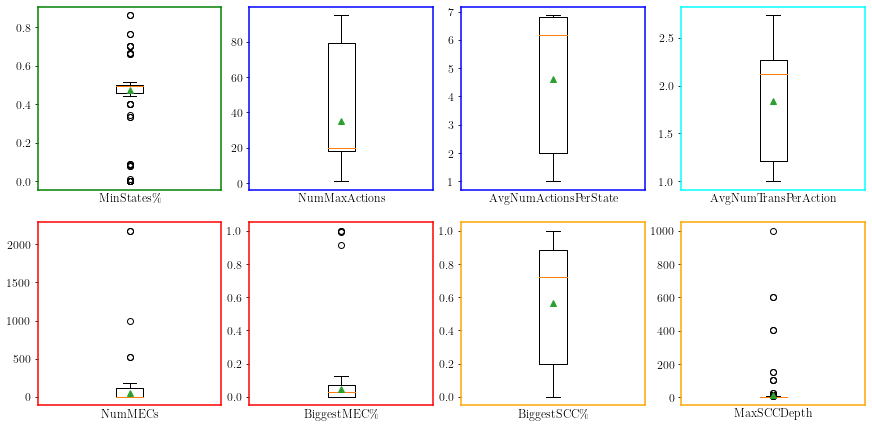

In [23]:
#Make Boxplots

boxplot_props = [
    ### States
    #"NumStates",
    #"Sinks"+r'\%',
    #"Unknown\%",
    "MinStates"+r'\%',
    
    ### Actions
    "NumMaxActions",
    "AvgNumActionsPerState",
    #"ProbActions\%",
    
    ### Transitions
    #"NumMaxTransitions",
    "AvgNumTransPerAction",
    #"SmallestTransProb",
    
    ### MEC
    "NumMECs",
    "BiggestMEC\%",
    #"AvgMEC\%",
    
    ### SCC
    #"NumSCCs",
    "BiggestSCC\%",
    #"AvgSCC\%",
    "MaxSCCDepth",
    
    ### SCCs with size >= 2
    #"NumNonSingleton",
    #"SmallestSCCNonSing",
    #"AvgSCCNonSing\%"
]
#boxplot_props = property_keys



#Map the plots to colors
plot_mapping = dict()
for key in [
    "NumStates",
    "NumSinks",
    "NumUnknown",
    "NumMinStates",
    "Sinks"+r'\%',
    "Unknown\%",
    "MinStates"+r'\%',
]:
    plot_mapping[key] = 'green'
    
for key in [
    "NumMaxActions",
    "AvgNumActionsPerState",
    "NumProbActions",
    "ProbActions\%",
]:
    plot_mapping[key] = 'blue'
    
for key in [
    "NumMaxTransitions",
    "AvgNumTransPerAction",
    "SmallestTransProb",
]:
    plot_mapping[key] = 'cyan'
    
for key in [
    "NumMECs",
    "BiggestMEC",''
    "AvgMEC",
    "BiggestMEC\%",
    "AvgMEC\%",
]:
    plot_mapping[key] = 'red'
    
for key in [
    # SCC
    "NumSCCs",
    "BiggestSCC",
    "AvgSCC",
    "MaxSCCDepth",
    "BiggestSCC\%",
    "AvgSCC\%",
    
    # SCCs with size >= 2
    "NumNonSingleton",
    "SmallestSCCNonSing",
    "AvgSCCNonSing\%"
]:
    plot_mapping[key] = 'orange'


entries_per_column = 4
entries_per_row = int(math.ceil(len(boxplot_props)/entries_per_column))
fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,6), constrained_layout=True)
row = 0
column = 0
for property_key in boxplot_props:
        if (column == entries_per_column):
            row += 1
            column = 0
            
        if (property_key == ""):
            
            column+=1
            continue
            
        minimal_value = 0    
        # Use log-scale for data with high numbers
        WHEN_TO_USE_LOG_SCALE = [
            property_key == "SmallestTransProb",
            property_key == "NumStates",
            #property_key == "SmallestTransProb"
            #np.max(data[property_key]) > 1e4
        ]
        if (np.any(WHEN_TO_USE_LOG_SCALE)):
            axs[row,column].set_yscale('log')
            minimal_value = 1e-6
            
        for spine in axs[row, column].spines.values():
            spine.set_edgecolor(plot_mapping[property_key])
            spine.set_linewidth(1.5)
            
        data_plotted = [max(x, minimal_value) for x in data[property_key]]       
        
        axs[row, column].boxplot(data_plotted, showmeans=True)
            
        axs[row, column].set_xlabel(property_key+"\n")
        
        axs[row, column].set_xticks([])
        axs[row, column].set_xticklabels([]) 
        column+=1
        
plt.savefig('RandomSCC.pdf', bbox_inches='tight')

In [24]:
#Print out specific stuff you are interested in
data_as_np = dict(data)
for key in data_as_np.keys():
    data_as_np[key] = np.asarray(data_as_np[key])
    
#for key in property_keys:    
for key in ["NumStates", "BiggestMEC", "BiggestMEC\%", "NumMECs", "NumProbActions", "AvgNumTransPerAction", "NumSCCs", "SmallestTransProb"]:
    print("Key: ", key)
    print("\t Min: ",data_as_np[key].min())
    print("\t Max: ",data_as_np[key].max())
    print("\t Mean: ",data_as_np[key].mean())

Key:  NumStates
	 Min:  11.0
	 Max:  10000004.0
	 Mean:  191777.32102272726
Key:  BiggestMEC
	 Min:  -0.09090909090909091
	 Max:  0.9999000149977504
	 Mean:  0.0465764486431059
Key:  BiggestMEC\%
	 Min:  -0.09090909090909091
	 Max:  0.9999000149977504
	 Mean:  0.0465764486431059
Key:  NumMECs
	 Min:  0.0
	 Max:  2176.0
	 Mean:  57.80113636363637
Key:  NumProbActions
	 Min:  4.999500049995001e-05
	 Max:  0.9512195121951219
	 Mean:  0.5106878295789528
Key:  AvgNumTransPerAction
	 Min:  1.00005
	 Max:  2.737449
	 Mean:  1.8403617982954545
Key:  NumSCCs
	 Min:  2.0
	 Max:  1236595.0
	 Mean:  13122.286931818182
Key:  SmallestTransProb
	 Min:  0.0
	 Max:  0.5
	 Mean:  0.024532291666666664



## Look at some graph to gain understanding of dataset

In [25]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [26]:
# Create Color mapping for confs
colorMapping = dict()

color_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
random.seed(12)
for conf in config_keys:
    colorMapping[conf] = color_palette[random.randint(0, len(color_palette)-1)]

for conf in config_keys:
    if ("BVI" == conf):
        colorMapping[conf] = '#1f77b4'
    elif ("OVI" == conf):
        colorMapping[conf] = '#ff7f0e'
    elif ("WP_P3" == conf):
        colorMapping[conf] = '#2ca02c'
    elif ("T_LP_SI" == conf):
        colorMapping[conf] = '#d62728'
    elif ("VI" == conf):
        colorMapping[conf] = '#7f7f7f'
    elif ("TOP_BVI" == conf):
        colorMapping[conf] = '#9467bd'
    elif ("T_BVI" == conf):
        colorMapping[conf] = '#9467bd'

        
lineStyleMapping = dict()
for conf in config_keys:
    if ("BVI" in conf):
        lineStyleMapping[conf] = 'solid'
    elif ("SVI" in conf):
        lineStyleMapping[conf] = (0, (1, 1)) #'dotted'
    elif ("OVI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) # 'loosely dashed'
    elif ("VI" in conf):
        lineStyleMapping[conf] = (0,(5,1)) #densely dashed
    elif ("SI" in conf):
        lineStyleMapping[conf] = (0, (3, 5, 1, 5, 1, 5)) # 'dashdotted'
    elif ("WP" in conf):
        lineStyleMapping[conf] = 'solid'
        
for conf in config_keys:
    if ("BVI" in conf):
        lineStyleMapping[conf] = (0, (5, 10))
    elif ("SVI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) #'dotted'
    elif ("OVI" in conf):
        lineStyleMapping[conf] = 'solid' #(0, (5, 10)) # 'loosely dashed'
    elif ("VI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) #densely dashed
    elif ("SI" in conf):
        lineStyleMapping[conf] = (0, (5, 10)) # 'dashdotted'
    elif ("WP" in conf):
        lineStyleMapping[conf] = (0, (5, 10))
        
markerMapping = dict()
"""
for conf in config_keys:
    if ("D_" in conf):
        markerMapping[conf] = "*" # start
    elif ("T_" in conf):
        markerMapping[conf] = "X" # x (filled)
    elif ("TOP_" in conf):
        markerMapping[conf] = "D" # diamond
    elif ("G_" in conf):
        markerMapping[conf] = "s" # square
    elif ("LP_" in conf):
        markerMapping[conf] = "p" # pentagon
    #elif ("WP" in conf):
        #markerMapping[conf] = "o" # circle
    else:
        markerMapping[conf] = "v" # triangle down
"""

for conf in config_keys:
    if ("BVI" in conf):
        markerMapping[conf] = "*" # start
    elif ("OVI" in conf):
        markerMapping[conf] = "X" # x (filled)
    elif ("SVI" in conf):
        markerMapping[conf] = "D" # diamond
    elif ("VI" in conf):
        markerMapping[conf] = "s" # square
    elif ("WP" in conf):
        markerMapping[conf] = "p" # pentagon
    elif ("TOP_BVI" in conf):
        markerMapping[conf] = "o" # circle
    elif ("T_SI_SI" in conf):
        markerMapping[conf] = "v" # triangle
    else:
        markerMapping[conf] = "."

In [27]:
print(data.keys())

dict_keys(['NumStates', 'NumActions', 'NumTargets', 'NumSinks', 'NumUnknown', 'NumMaxActions', 'NumMaxTransitions', 'SmallestTransProb', 'NumProbActions', 'NumMECs', 'BiggestMEC', 'SmallestMEC', 'AvgMEC', 'MedianMEC', 'NumSCCs', 'BiggestSCC', 'AvgSCC', 'NearestTarget', 'FurthestTarget', 'AvgNumActionsPerState', 'AvgNumTransPerAction', 'NumMaxStates', 'NumMinStates', 'NumBackwardsTransitions', 'MaxSCCDepth', 'NumNonSingleton', 'SmallestSCCNonSing', 'AvgSccNonSing', 'WP_P3', 'T_LP_SI', 'OVI', 'BVI', 'TOP_BVI', 'LP_SI', 'SI_SI', 'SI', 'values_WP_P3', 'values_T_LP_SI', 'values_OVI', 'values_BVI', 'values_TOP_BVI', 'values_LP_SI', 'values_SI_SI', 'values_SI', 'iters_WP_P3', 'iters_T_LP_SI', 'iters_OVI', 'iters_BVI', 'iters_TOP_BVI', 'iters_LP_SI', 'iters_SI_SI', 'iters_SI', 'Sinks\\%', 'Targets\\%', 'Unknown\\%', 'MinStates\\%', 'ProbActions\\%', 'BiggestSCC\\%', 'AvgSCC\\%', 'AvgSCCNonSing\\%', 'BiggestMEC\\%', 'AvgMEC\\%'])


In [28]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "normal",
    #"font.sans-serif": ["Helvetica"],
    "font.weight" : 18

})

params = {
    'mathtext.default': 'rm',
}          
plt.rcParams.update(params)

Conf $\mathrm{OVI}$: 	12308.409000 	 Not Finished / Error / Wrong Result: 	 1
Conf $\mathrm{WP}$: 	9322.867000 	 Not Finished / Error / Wrong Result: 	 2
Conf $\mathrm{BVI}$: 	11977.464000 	 Not Finished / Error / Wrong Result: 	 5
Conf $\mathrm{SI_{LP}}$: 	8688.951000 	 Not Finished / Error / Wrong Result: 	 8
Conf $\mathrm{SI_{LP}^T}$: 	6410.947000 	 Not Finished / Error / Wrong Result: 	 9
Conf $\mathrm{BVI^{PT}}$: 	15316.476000 	 Not Finished / Error / Wrong Result: 	 29
Conf $\mathrm{SI_{VI}}$: 	6865.575000 	 Not Finished / Error / Wrong Result: 	 105
Conf $\mathrm{SI_{SI}}$: 	2303.869000 	 Not Finished / Error / Wrong Result: 	 200


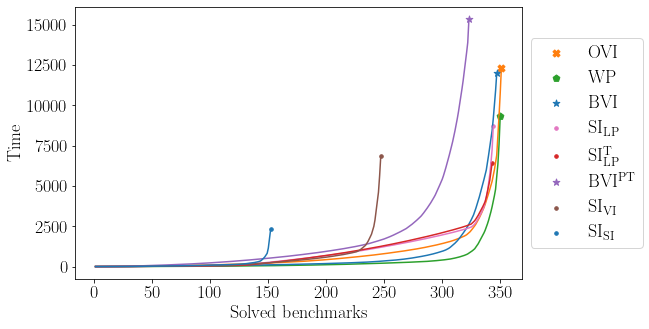

In [29]:
# Since we want to sort legend by when an algo stops (So e.g. condon first, as it solves only 5), we need this method to find min. 
# for_ordering is a dict that maps each algo to a tuple: (Number of solved benchmarks, time to solve them all)
myDict = dict()
for_ordering = dict()

def my_min(for_ordering):
    min = (math.inf,math.inf) #certainly greater, as only 34 benchmarks
    min_algo = "None"
    for algo in for_ordering.keys():
        bench,time = for_ordering[algo]
        
        if bench < min[0] or (bench == min[0] and time > min[1]):
            min = (bench,time)
            min_algo = algo
    return min_algo

for algo in config_keys:
    subres = [float(i) for i in data[algo] if (i != PENTALY_FOR_NOT_FINISHING and i != -1)]
    subres.sort()
    myDict[algo] = [i for i in subres]
    if (subres == []):
        print("For Algo %s not one model was solved" % (algo))
    for_ordering[algo] = (len(subres),subres[len(subres)-1])

# Get a list of algos in order for the legend
ordered_algos = []
while bool(for_ordering):
    min_algo = my_min(for_ordering)
    ordered_algos += [min_algo]
    for_ordering.pop(min_algo)


#print(myDict)

fig1, ax1 = plt.subplots(figsize=(8,5))
ax1.set_xlabel("Solved benchmarks")
ax1.set_ylabel("Time")

#fig2, ax2 = plt.subplots()
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Solved benchmarks")


x = range(1,len(data["NumStates"])+1)

#x2 = range(0,1700)

legend_sorting = []
runtimes = dict()
errors = dict()
sorting = dict()

for conf in config_keys:
    runtimes[conf] = 0
    errors[conf] = 0
    sorting[conf] = 0
    for i in range(len(data[conf])):
        if (data[conf][i] != PENTALY_FOR_NOT_FINISHING and data[conf][i] != -1):
            runtimes[conf] += data[conf][i]
            sorting[conf] += data[conf][i]
        else:
            errors[conf] += 1
            sorting[conf] += PENTALY_FOR_NOT_FINISHING * 1000

    legend_sorting.append([conf, sorting[conf]])
    
    
legend_sorting.sort(key = lambda x : x[1])

for conf in legend_sorting:
    print("Conf %s: \t%f \t Not Finished / Error / Wrong Result: \t %i" % (label_mapping[conf[0]], runtimes[conf[0]], errors[conf[0]]))




ordered_algos.reverse()
for algo in ordered_algos:
    y = [sum(myDict[algo][:i+1]) for i in range(0,len(myDict[algo])) if myDict[algo][i] != PENTALY_FOR_NOT_FINISHING]
    ax1.plot([i for i in x if i<=len(myDict[algo])],y,
             c = colorMapping[algo],
             #linestyle = lineStyleMapping[algo],
            )
    ax1.scatter(x[len(myDict[algo])-1],y[len(myDict[algo])-1],
                label=label_mapping[algo],
                c = colorMapping[algo],
                marker=markerMapping[algo], s=50,
               )
    handles, labels = ax1.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: sorting[label_reverse_mapping[t[0]]]))
    #print(labels)
    #print(handles)
    ax1.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 18)
    #plt.legend(loc="upper left")
    """
    if algo == "19":
    ax1.plot([i for i in x if i<=len(myDict[algo])],y, label=algo, c='tab:brown', zorder=1)
    ax1.scatter(x[len(myDict[algo])-1],y[len(myDict[algo])-1], s=30, marker='*', c='tab:brown', zorder=2)
    """
    #ax1.set_ylim([0,20000])

fig1.savefig('Time2Bench.pdf', bbox_inches='tight')




In [30]:
loaded_datasets = list(map(lambda x: x.split('/')[-2] , LOAD_PATHS))
print(f'Average Times for {loaded_datasets} with PAR2:')

par_list = []
name_of_saved_file = 'pars_'
for loaded_dataset in loaded_datasets:
    name_of_saved_file += loaded_dataset + '_'
    
name_of_saved_file = name_of_saved_file[:-1:]
name_of_saved_file += '.csv'
print(name_of_saved_file)

for conf in legend_sorting:
    par1 =  (runtimes[conf[0]] + errors[conf[0]] * TIME_PENALTY) / len(data[conf[0]])
    par2 =  (runtimes[conf[0]] + errors[conf[0]] * TIME_PENALTY * 2) / len(data[conf[0]])
    par10 =  (runtimes[conf[0]] + errors[conf[0]] * TIME_PENALTY * 10) / len(data[conf[0]])
    par_list.append({'Conf' : label_mapping[conf[0]], 'PAR1' : par1, 'PAR2' : par2, 'PAR10' : par10, '#No/Wrong Result': errors[conf[0]]})

dataframe = pd.DataFrame(par_list)
dataframe.to_csv(name_of_saved_file, index=False)

Average Times for ['realModels_2', 'realModels', 'handcraftedModels', 'randomRandomThesis', 'randomRandom10Act', 'randomSCCFixed_2', 'bigConfModels'] with PAR2:
pars_realModels_2_realModels_handcraftedModels_randomRandomThesis_randomRandom10Act_randomSCCFixed_2_bigConfModels.csv


In [31]:
print(data.keys())

dict_keys(['NumStates', 'NumActions', 'NumTargets', 'NumSinks', 'NumUnknown', 'NumMaxActions', 'NumMaxTransitions', 'SmallestTransProb', 'NumProbActions', 'NumMECs', 'BiggestMEC', 'SmallestMEC', 'AvgMEC', 'MedianMEC', 'NumSCCs', 'BiggestSCC', 'AvgSCC', 'NearestTarget', 'FurthestTarget', 'AvgNumActionsPerState', 'AvgNumTransPerAction', 'NumMaxStates', 'NumMinStates', 'NumBackwardsTransitions', 'MaxSCCDepth', 'NumNonSingleton', 'SmallestSCCNonSing', 'AvgSccNonSing', 'WP_P3', 'T_LP_SI', 'OVI', 'BVI', 'TOP_BVI', 'LP_SI', 'SI_SI', 'SI', 'values_WP_P3', 'values_T_LP_SI', 'values_OVI', 'values_BVI', 'values_TOP_BVI', 'values_LP_SI', 'values_SI_SI', 'values_SI', 'iters_WP_P3', 'iters_T_LP_SI', 'iters_OVI', 'iters_BVI', 'iters_TOP_BVI', 'iters_LP_SI', 'iters_SI_SI', 'iters_SI', 'Sinks\\%', 'Targets\\%', 'Unknown\\%', 'MinStates\\%', 'ProbActions\\%', 'BiggestSCC\\%', 'AvgSCC\\%', 'AvgSCCNonSing\\%', 'BiggestMEC\\%', 'AvgMEC\\%'])


In [32]:
# DELETE THIS CELL AFTER TACAS

investigate = "ovi_itersOVI_NumInduceLowerBound"

## Restore BiggestSCC values
#for i in range(len(data[investigate])):
#    data[investigate][i] = data["NumStates"][i] * data["BiggestSCC%"][i]

min_actions = np.array(data[investigate]).min()
max_actions = np.array(data[investigate]).max()
print(min_actions)
print(max_actions)
scatter_coloring = []
"""
for i in range(len(data[investigate])):
    if (data[investigate][i] == 0):
        percent = 1
    else:    
        percent = (data[investigate][i] - min_actions) / (max_actions - min_actions)
        if (data[investigate][i] == 2):
            percent += 0.25
    scatter_coloring.append(percent)
    print(data[investigate][i])
    print(percent)
"""

"""
for i in range(len(data[investigate])):
    percent = (data[investigate][i] - min_actions) / (max_actions - min_actions)
    if (data[investigate][i] >= 3.25 and data[investigate][i] <= 9):
        percent += 0.5#0.1*data[investigate][i]
    scatter_coloring.append(percent)
    print(data[investigate][i])
    print(percent)
"""

for i in range(len(data[investigate])):
    percent = max(min(data[investigate][i] / max_actions, 1), 0)
    #if (percent < 0.35):
    #    percent -= 0.2
    #if (percent > 0.5):
    #    percent += 0.2
    scatter_coloring.append(percent)
    #print(data[investigate][i])
    #print(percent)

KeyError: 'ovi_itersOVI_NumInduceLowerBound'

In [33]:
### PROPERTIES

investigate = "BiggestMEC"

## Restore BiggestMEC values
for i in range(len(data[investigate])):
    data[investigate][i] = data["NumStates"][i] * data["BiggestMEC\\%"][i]
    if (data[investigate][i] == -1):
        data[investigate][i] = 10000

min_actions = min(0, np.array(data[investigate]).min())
max_actions = 5000#np.array(data[investigate]).max()
print(min_actions)
print(max_actions)
scatter_coloring = []
"""
for i in range(len(data[investigate])):
    if (data[investigate][i] == 0):
        percent = 1
    else:    
        percent = (data[investigate][i] - min_actions) / (max_actions - min_actions)
        if (data[investigate][i] == 2):
            percent += 0.25
    scatter_coloring.append(percent)
    print(data[investigate][i])
    print(percent)
"""

"""
for i in range(len(data[investigate])):
    percent = (data[investigate][i] - min_actions) / (max_actions - min_actions)
    if (data[investigate][i] >= 3.25 and data[investigate][i] <= 9):
        percent += 0.5#0.1*data[investigate][i]
    scatter_coloring.append(percent)
    print(data[investigate][i])
    print(percent)
"""

for i in range(len(data[investigate])):
    percent = max(min(data[investigate][i] / max_actions, 1), 0)
    if (percent >= 0.05 and percent <= 0.3):
        percent += 0.2
    #if (percent > 0.5):
    #    percent += 0.2
    scatter_coloring.append(percent)
    #print(data[investigate][i])
    #print(percent)

0
5000


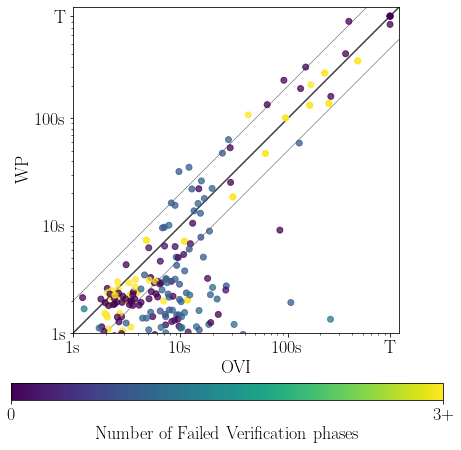

In [34]:
#Use scale that doubles itself (as in OVI paper)
algo_on_x = "OVI"
algo_on_y = "WP_P3"

#Transform Data
data_for_x = data[algo_on_x].copy()
data_for_y = data[algo_on_y].copy()

ticks = []
ticklabels = []
for i in range(0, 3 if not USE_ITERS else 6):
    ticks.append(10**i)
    tick_label = str(10**i)
    if (USE_TIMES):
        tick_label += "s"
    ticklabels.append(tick_label)
ticks.append(PENTALY_FOR_NOT_FINISHING)
axis_limits = [1, PENTALY_FOR_NOT_FINISHING+200]
ticklabels.append("T")

for i in range(len(data_for_x)):
    if (data_for_x[i] > axis_limits[1]):
        data_for_x[i] = axis_limits[1] - 200
    #if (data_for_x[i] < axis_limits[0]):
    #    data_for_x[i] = axis_limits[0]

for i in range(len(data_for_y)):
    if (data_for_y[i] > axis_limits[1]):
        data_for_y[i] = axis_limits[1] - 200
    #if (data_for_y[i] < axis_limits[0]):
    #    data_for_y[i] = axis_limits[0]
    
colormap = 'viridis'
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data_for_x, data_for_y, alpha = 0.75, c = scatter_coloring, cmap = colormap)

label_prios = dict()
label_prios[">=5 / Timeout"] = max_actions
label_prios["2 - 4"] = 2
label_prios["1"] = min_actions

ax.scatter([0.1], [0.1], c = ["black"], label=">=5 / Timeout")
ax.scatter([0.1], [0.1], c = ["#299086"], label="2 - 4")
ax.scatter([0.1], [0.1], c = ["#451d6c"], label="1")


ax.plot(axis_limits, axis_limits, 'k-', alpha=0.75, zorder=0)
ax.plot(list(map(lambda x : x * 2, axis_limits)), axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
ax.plot(list(map(lambda x : x / 2, axis_limits)), axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
ax.set_aspect('equal')
ax.set_xlabel(label_mapping[algo_on_x])
ax.set_ylabel(label_mapping[algo_on_y])
ax.set_xlim(axis_limits)
ax.set_ylim(axis_limits)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)

# handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: label_prios[t[0]]))
#print(labels)
#print(handles)

cax = plt.axes([0.2, -0.03, 0.6, 0.04])
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=colormap),
             cax=cax, orientation='horizontal', label='Number of Failed Verification phases')
cbar.set_ticks([0, 1])
cbar.ax.set_xticklabels(['0', '3+'])

#ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.savefig('colorScatter.pdf', bbox_inches='tight')

#### Vanilla vs Optim Scatters

No handles with labels found to put in legend.


D_BVI not in Data - have you included it in the notebook and in the benchmarks?
D_OVI not in Data - have you included it in the notebook and in the benchmarks?
D_LP_SI not in Data - have you included it in the notebook and in the benchmarks?


No handles with labels found to put in legend.


G_BVI not in Data - have you included it in the notebook and in the benchmarks?
G_OVI not in Data - have you included it in the notebook and in the benchmarks?
G_LP_SI not in Data - have you included it in the notebook and in the benchmarks?
TOP_OVI not in Data - have you included it in the notebook and in the benchmarks?
TOP_LP_SI not in Data - have you included it in the notebook and in the benchmarks?
T_BVI not in Data - have you included it in the notebook and in the benchmarks?
T_OVI not in Data - have you included it in the notebook and in the benchmarks?


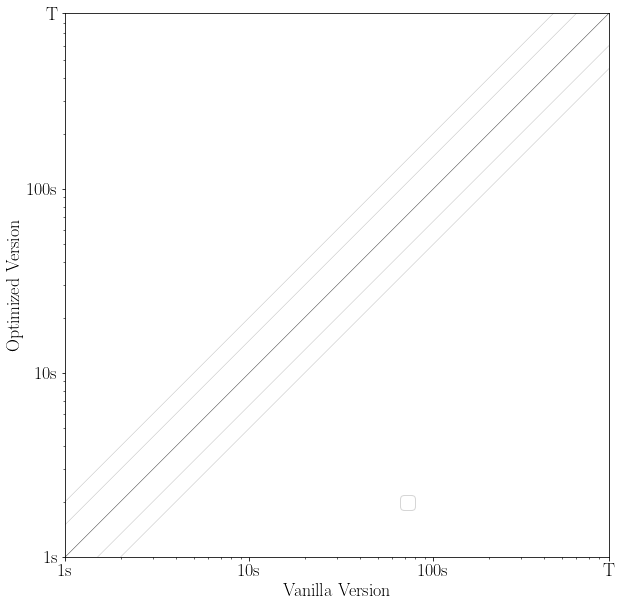

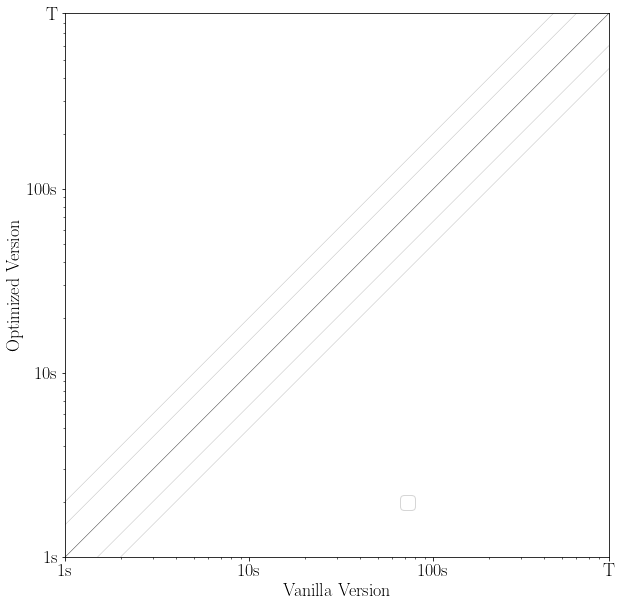

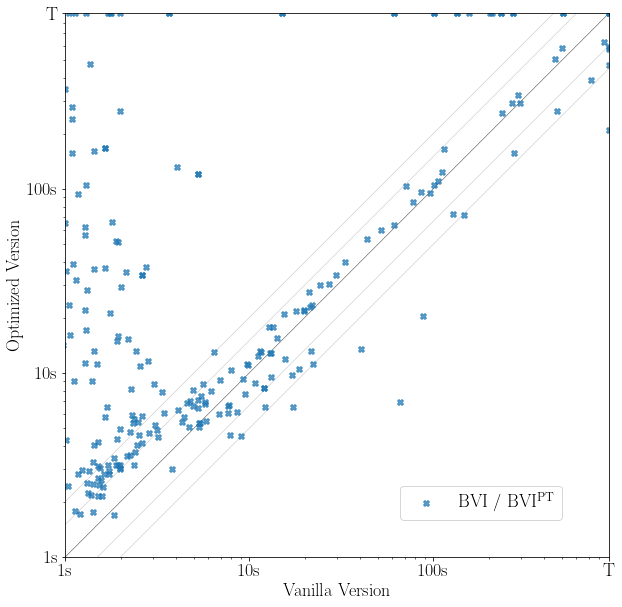

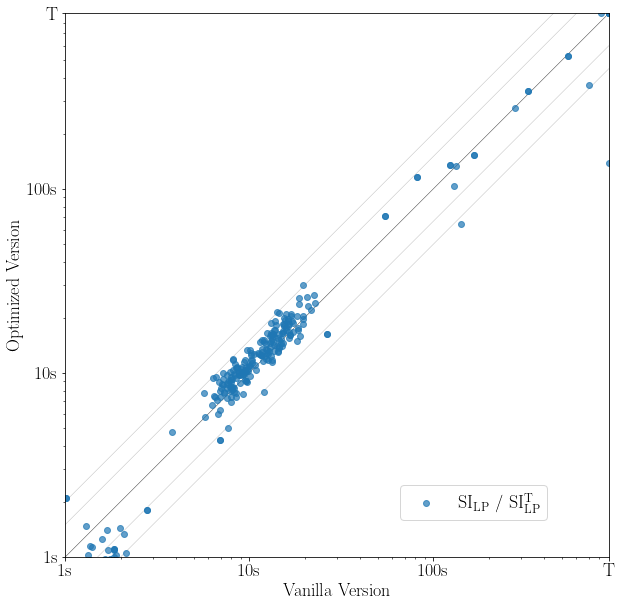

In [35]:
base_algos = ["BVI", "OVI", "LP_SI"]
extensions = [
    "D", 
    "G", 
    "TOP", 
    "T", 
    #"OPT"
]

# PyPlot settings Settings
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


i = 0
while 10**i <= PENTALY_FOR_NOT_FINISHING:
    ticks.append(10**i)
    ticklabels.append(str(10**i))
    i+=1
ticks.append(PENTALY_FOR_NOT_FINISHING)
axis_limits = [1, PENTALY_FOR_NOT_FINISHING]
ticklabels.append("Timeout / Error")

ticks = []
ticklabels = []
for i in range(0, 3 if not USE_ITERS else 6):
    ticks.append(10**i)
    tick_label = str(10**i)
    if (USE_TIMES):
        tick_label += "s"
    ticklabels.append(tick_label)
ticks.append(PENTALY_FOR_NOT_FINISHING)
ticklabels.append("T")
#ticklabels[-1] = "Timeout / Error"

algo_to_marker = dict()
algo_to_marker["BVI"] = "X"
algo_to_marker["SVI"] = "^"
algo_to_marker["OVI"] = "s"
algo_to_marker["LP_SI"] = "o"


market_to_size = dict()



for extension in extensions:
    fig, ax = plt.subplots(figsize=(10,10))
    for base_algo in base_algos:
        optim_algo = extension+"_"+base_algo
        if (optim_algo not in data):
            print("%s not in Data - have you included it in the notebook and in the benchmarks?" % optim_algo)
            continue

        data_for_x = data[base_algo].copy()
        data_for_y = data[optim_algo].copy()

        for i in range(len(data_for_x)):
            if (data_for_x[i] > axis_limits[1]):
                data_for_x[i] = axis_limits[1]

        for i in range(len(data_for_y)):
            if (data_for_y[i] > axis_limits[1]):
                data_for_y[i] = axis_limits[1]

        ax.scatter(data_for_x, data_for_y, label=("%s / %s" % (label_mapping[base_algo], label_mapping[optim_algo])), alpha = 0.7, marker=algo_to_marker[base_algo])

    
    ax.plot(axis_limits, axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x * 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x * 1.5, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x / 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x / 1.5, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("Vanilla Version")
    ax.set_ylabel("Optimized Version")
    
    ax.set_xlim(axis_limits)
    ax.set_ylim(axis_limits) 
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    plt.legend(loc='center left', bbox_to_anchor=(0.60, 0.1), fontsize = 18)
    
    
    
    plotname = 'Scatter_'+extension
    if (USE_ITERS):
        plotname+='_iters'
    plotname+='.pdf'
    
    plt.savefig(plotname, bbox_inches='tight')


#### One Algorithm against others

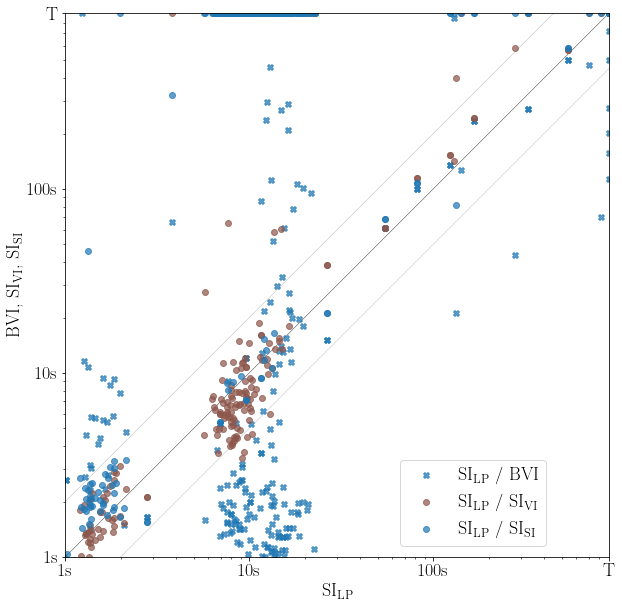

In [36]:
bottom_algos = ["LP_SI"]
against_algos = ["BVI", "SI", "SI_SI"]


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

axis_limits = [
    10**0 if (USE_TIMES) else 1,
    10**3 if (USE_TIMES) else 10**5
]

ticks = []
ticklabels = []
#for i in range(0, 3 if USE_TIMES else 6):
#    ticks.append(10**i)
#    ticklabels.append(str(10**i)+"")
#ticks.append(PENTALY_FOR_NOT_FINISHING)
#ticklabels.append("Timeout / Error")
#ticks = [1, 10, 100, 900]
#ticklabels = [1, 10, 100, 900]
#axis_limits = [1, 900]

i = 0
axis_limits = [10**i, PENTALY_FOR_NOT_FINISHING]
while 10**i <= PENTALY_FOR_NOT_FINISHING:
    ticks.append(10**i)
    ticklabel = str(10**i)
    if (USE_TIMES):
        ticklabel += "s"
    ticklabels.append(ticklabel)
    i+=1
ticks.append(PENTALY_FOR_NOT_FINISHING)
#ticklabels.append("Timeout / Error")
ticklabels.append("T")

algo_to_marker = dict()
# Set default marker
for conf in config_keys:
    algo_to_marker[conf] = "o"
algo_to_marker["BVI"] = "X"
algo_to_marker["SVI"] = "^"
algo_to_marker["OVI"] = "s"
algo_to_marker["T_LP_SI"] = "X"
algo_to_marker["T_SI_SI"] = "^"

market_to_size = dict()

def list_to_string(l):
    x = ""
    for i in l:
        x+=str(i)+", "
    x = x[0:-2]
    return x

for bottom_algo in bottom_algos:
    fig, ax = plt.subplots(figsize=(10,10))
    for against_algo in against_algos:
        if (against_algo not in data):
            print("%s is not in Data? " % against_algo)
        if (bottom_algo not in data):
            print("%s is not in Data? " % bottom_algo)

        data_for_x = data[bottom_algo].copy()
        data_for_y = data[against_algo].copy()

        for i in range(len(data_for_x)):
            if (data_for_x[i] > axis_limits[1]):
                data_for_x[i] = axis_limits[1]

        for i in range(len(data_for_y)):
            if (data_for_y[i] > axis_limits[1]):
                data_for_y[i] = axis_limits[1]
            

        ax.scatter(data_for_x, 
                   data_for_y, 
                   label=("%s / %s" % (label_mapping[bottom_algo], label_mapping[against_algo])), 
                   alpha = 0.7, 
                   marker=algo_to_marker[against_algo],
                   c = colorMapping[against_algo]
                  )

    ax.plot(axis_limits, axis_limits, 'k-', alpha=0.75, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x * 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.plot(list(map(lambda x : x / 2, axis_limits)), axis_limits, 'k-', alpha=0.25, zorder=0, linewidth = 0.5)
    ax.set_aspect('equal')
    ax.set_xlabel(label_mapping[bottom_algo])
    ax.set_ylabel(list_to_string(list(map(lambda alg : label_mapping[alg], against_algos))))
    
    ax.set_xlim(axis_limits)
    ax.set_ylim(axis_limits) 
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    plt.legend(loc='center left', bbox_to_anchor=(0.60, 0.1), fontsize = 18)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
    
plt.savefig('performanceScatter.pdf', bbox_inches='tight')

# Tell me more about the models where ...

In [37]:
#DELETE THIS CELL AFTER TACAS
random_model_indices = []
non_random_model_indices = []
for i in range(len(data['NumStates'])):
    model = model_names[i]
    
    if ("RANDOM" in model):
        random_model_indices.append(i)
    else:
        non_random_model_indices.append(i)
        
print(non_random_model_indices)
print(list(map(lambda x : model_names[x], non_random_model_indices)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
['simple_10000000_1_SCC', 'simple_10000000_5_SCC', 'simple_1000000_1_SCC', 'simple_1000000_5_SCC', 'simple_100000_1_SCC', 'simple_100000_5_SCC', 'simple_2000000_1_SCC', 'simple_2000000_5_SCC', 'simple_3000000_1_SCC', 'simple_3000000_5_SCC', 'simple_4000000_1_SCC', 'simple_4000000_5_SCC', 'simple_5000000_1_SCC', 'simple_5000000_5_SCC', 'simple_500000_1_SCC', 'simple_500000_5_SCC', 'simple_50000_1_SCC', 'simple_50000_5_SCC', 'AV10_10_2', 'AV10_10_3', 'AV15_15_2', 'AV15_15_3', 'adt', 'charlton1', 'charlton2', 'cloud5', 'cloud6', 'coins', 'dice100', 'dice150', 'dice50', 'hallway10_10_2', 'hallway15_15_2', 'mdsm1', 'prison_dil', 'two_investors', 'AV10_10_2', 'AV10_10_3', 'AV15_15_2', 'AV15_15_3', 'adt', 'charlton1', 'charlton2', 'cloud5', 'cloud6',

In [38]:
# Define comparation functions
def compare_two_confs(conf_a, conf_b, keep_only_if_function_is_true):
    model_indices = []
    for i in range(len(data['NumStates'])):
        model = model_names[i]

        model_is_interesting = True
        for f in keep_only_if_function_is_true:
            if (not f(data[conf_a][i], data[conf_b][i])):
                model_is_interesting = False
                break 
        if not model_is_interesting:
            continue
        
        model_indices.append(i)
    return model_indices 

In [39]:
# Define evaluation
def evaluate_conf_comparison(conf_a, conf_b, filtered_indices, interesting_props):
    evaluation_df = []
    for index in filtered_indices:
        model_name = model_names[index]
        print("Model: %s" % model_name)
        print("%s: %f" % (conf_a, data[conf_a][index]))
        print("%s: %f" % (conf_b, data[conf_b][index]))

        evaluation_df.append({"Model" : model_names[index], conf_a : data[conf_a][index], conf_b : data[conf_b][index]})
        for prop_key in interesting_props:
            print("%s: %f" % (prop_key, data[prop_key][index]))

    return pd.DataFrame(evaluation_df)

In [40]:
interesting_props = [
    "NumMaxActions",
    "AvgNumActionsPerState"
]
#interesting_props = property_keys
interesting_props = []


exclude_props = [
    "NumSinks",
    "NumTargets",
    
]

In [41]:
# Get Results - Example
conf_a = "BVI"
conf_b = "LP_SI"
event_a = compare_two_confs(conf_a, conf_b, [lambda x,y : x > 1.5 * y and x > 3])
counter_event_a = compare_two_confs(conf_a, conf_b, [lambda x,y : x <= 2])
mirror_event_a = compare_two_confs(conf_a, conf_b, [lambda x,y : y > 2 * x and x > 3])
print(len(event_a))
print(len(mirror_event_a))
print(len(counter_event_a))
evaluate_conf_comparison(conf_a, conf_b, event_a, [])

#interesting_props = ["BiggestSCC", "BiggestMEC"]
evaluation_df = evaluate_conf_comparison(conf_a, conf_b, event_a, interesting_props)
print(interesting_props)


64
16
203
Model: simple_100000_5_SCC
BVI: 21.745000
LP_SI: 12.091000
Model: BigMec_1e3
BVI: 10.723000
LP_SI: 1.323000
Model: BigMec_1e4
BVI: 845.599000
LP_SI: 129.955000
Model: ManyMECs_1e3
BVI: 65.936000
LP_SI: 3.796000
Model: hm_20
BVI: 147.363000
LP_SI: 0.081000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_11
BVI: 29.706000
LP_SI: 14.075000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_12
BVI: 290.417000
LP_SI: 16.264000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_13
BVI: 457.113000
LP_SI: 12.958000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_22
BVI: 209.104000
LP_SI: 16.170000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_29
BVI: 24.161000
LP_SI: 13.015000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_30
BVI: 900.000000
LP_SI: 22.855000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_34
BVI: 77.580000
LP_SI: 17.244000
Model: RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Mod

In [42]:
evaluation_df.head()

,Model,BVI,LP_SI
0,simple_100000_5_SCC,21.745,12.091
1,BigMec_1e3,10.723,1.323
2,BigMec_1e4,845.599,129.955
3,ManyMECs_1e3,65.936,3.796
4,hm_20,147.363,0.081


In [79]:
print(evaluation_df)
evaluation_df.to_csv("evaluation_df.csv", sep=",", index=False)

                                                Model      BVI    LP_SI
0                                 simple_100000_5_SCC   21.745   12.091
1                                          BigMec_1e3   10.723    1.323
2                                          BigMec_1e4  845.599  129.955
3                                        ManyMECs_1e3   65.936    3.796
4                                               hm_20  147.363    0.081
..                                                ...      ...      ...
59  RANDOM_Size_10002_MinAct_10_Type-scc_MinTransP...    7.700    0.688
60  RANDOM_Size_10002_MinAct_10_Type-scc_MinTransP...   12.252    0.606
61  RANDOM_Size_10002_MinAct_10_Type-scc_MinTransP...  900.000    0.783
62  RANDOM_Size_10002_MinAct_10_Type-scc_MinTransP...    5.428    1.683
63  RANDOM_Size_10002_MinAct_10_Type-scc_MinTransP...    7.825    0.622

[64 rows x 3 columns]


In [898]:
conf_a = "iters_WP_P3"
conf_b = "iters_OVI"
wp_no_iters = compare_two_confs(conf_a, conf_b, [lambda x,y : x == 1 and y != 1])
wp_mul_iters = compare_two_confs(conf_a, conf_b, [lambda x,y : x != 1])

for i in wp_no_iters:

    print(f'Time: {conf_a}: {data[conf_a][i]}, {conf_b}: {data[conf_b][i]}')
    print(f'TIME: "BVI": {data["BVI"][i]}, "OVI": {data["OVI"][i]}')
    #print("Iter: BVI: %f, OVI: %f, OII: %f" % (data["Iter_"+bvi][i], data["Iter_"+ovi][i], data["Iter_"+oii][i]))

    PROP_ANALYSIS = True
    if (PROP_ANALYSIS):
        print(f'Model: {model_names[i]}')
        for key in interesting_props:
            #print(f'\t{key}: {data[key][i]}')
            pass
    
    
    
    FILE_ANALYSIS = False
    
    if (FILE_ANALYSIS):
        print("Let's find out more about the OII file!")
        lines_to_print = [
            #"Time spent Deflating: ",
            #"Total Lower Verification Iterations: ",
            #"Total Upper Verification Iterations: ",
            #"Upper and Lower bounds are eps-close -> BVI iteration criterion met",
            #"Lowerjumps"
        ]
        print("Model: %s" % (model_names[i]))
        with open(PATH_TO_CSV_FOLDER+oii+"/"+model_names[i]+".log") as logfile:
            for line in logfile:
                for interesting_line_segment in lines_to_print:
                    if (interesting_line_segment in line):
                        line = line.replace("\n", "")
                        print(line)

NameError: name 'compare_two_confs' is not defined

In [899]:
data.keys()

dict_keys(['NumStates', 'NumActions', 'NumTargets', 'NumSinks', 'NumUnknown', 'NumMaxActions', 'NumMaxTransitions', 'SmallestTransProb', 'NumProbActions', 'NumMECs', 'BiggestMEC', 'SmallestMEC', 'AvgMEC', 'MedianMEC', 'NumSCCs', 'BiggestSCC', 'AvgSCC', 'NearestTarget', 'FurthestTarget', 'AvgNumActionsPerState', 'AvgNumTransPerAction', 'NumMaxStates', 'NumMinStates', 'NumBackwardsTransitions', 'MaxSCCDepth', 'NumNonSingleton', 'SmallestSCCNonSing', 'AvgSccNonSing', 'WP_P3', 'T_LP_SI', 'VI', 'OVI', 'BVI', 'TOP_BVI', 'T_BVI', 'D_BVI', 'G_BVI', 'G_OVI', 'LP_SI', 'values_WP_P3', 'values_T_LP_SI', 'values_VI', 'values_OVI', 'values_BVI', 'values_TOP_BVI', 'values_T_BVI', 'values_D_BVI', 'values_G_BVI', 'values_G_OVI', 'values_LP_SI', 'iters_WP_P3', 'iters_T_LP_SI', 'iters_VI', 'iters_OVI', 'iters_BVI', 'iters_TOP_BVI', 'iters_T_BVI', 'iters_D_BVI', 'iters_G_BVI', 'iters_G_OVI', 'iters_LP_SI', 'Sinks\\%', 'Targets\\%', 'Unknown\\%', 'MinStates\\%', 'ProbActions\\%', 'BiggestSCC\\%', 'AvgSCC\\

In [900]:
# Your section to get info you are interested in
conf_a = "ovi_itersOVI_NumFailedVerif"
conf_b = "WP_P3"

confA_worse_than_confB = compare_two_confs(conf_a, conf_b, [lambda x,y : x > y * 3 and x > 5 and y > 5])
counter_event = compare_two_confs(conf_a, conf_b, [lambda x,y : x < 3 * y and x > 5])

print(f'Event A occurred {len(confA_worse_than_confB)} times')
print(f'CounterEvent occurred {len(counter_event)} times')

intersection = confA_worse_than_confB
print("Number of occurance: %d" % (len(intersection)))

interesting_props = []

for i in intersection:
    print(f'Time: {conf_a}: {data[conf_a][i]}, {conf_b}: {data[conf_b][i]}')
    #print("Iter: BVI: %f, OVI: %f, OII: %f" % (data["Iter_"+bvi][i], data["Iter_"+ovi][i], data["Iter_"+oii][i]))

    PROP_ANALYSIS = True
    if (PROP_ANALYSIS):
        print(f'Model: {model_names[i]}')
        for key in interesting_props:
            print(f'\t{key}: {data[key][i]}')
    
    
    
    FILE_ANALYSIS = False
    
    if (FILE_ANALYSIS):
        print("Let's find out more about the OII file!")
        lines_to_print = [
            #"Time spent Deflating: ",
            #"Total Lower Verification Iterations: ",
            #"Total Upper Verification Iterations: ",
            #"Upper and Lower bounds are eps-close -> BVI iteration criterion met",
            #"Lowerjumps"
        ]
        print("Model: %s" % (model_names[i]))
        with open(PATH_TO_CSV_FOLDER+oii+"/"+model_names[i]+".log") as logfile:
            for line in logfile:
                for interesting_line_segment in lines_to_print:
                    if (interesting_line_segment in line):
                        line = line.replace("\n", "")
                        print(line)

NameError: name 'compare_two_confs' is not defined

In [279]:
y = []
for i in range(len(data["ovi_itersOVI_NumFailedVerif"])):
    if (data["ovi_itersOVI_NumFailedVerif"][i] == 1):
        y.append(i)
print(y)
for i in y:
    #print("Iter: BVI: %f, OVI: %f, OII: %f" % (data["Iter_"+bvi][i], data["Iter_"+ovi][i], data["Iter_"+oii][i]))

    PROP_ANALYSIS = True
    if (PROP_ANALYSIS):
        print(f'Model: {model_names[i]}')
        for key in interesting_props:
            print(f'\t{key}: {data[key][i]}')
    
    
    
    FILE_ANALYSIS = False
    
    if (FILE_ANALYSIS):
        print("Let's find out more about the OII file!")
        lines_to_print = [
            #"Time spent Deflating: ",
            #"Total Lower Verification Iterations: ",
            #"Total Upper Verification Iterations: ",
            #"Upper and Lower bounds are eps-close -> BVI iteration criterion met",
            #"Lowerjumps"
        ]
        print("Model: %s" % (model_names[i]))
        with open(PATH_TO_CSV_FOLDER+oii+"/"+model_names[i]+".log") as logfile:
            for line in logfile:
                for interesting_line_segment in lines_to_print:
                    if (interesting_line_segment in line):
                        line = line.replace("\n", "")
                        print(line)


[]


In [4324]:
oii_worse_than_bvi = compare_two_confs(oii, bvi, [lambda x,y : x > 3 * y and y > 1])
print(len(oii_worse_than_bvi))
for i in oii_worse_than_bvi:
    print("Time: BVI: %f, OVI: %f, OII: %f" % (data[bvi][i], data[ovi][i], data[oii][i]))
    #print("Iter: BVI: %f, OVI: %f, OII: %f" % (data["Iter_"+bvi][i], data["Iter_"+ovi][i], data["Iter_"+oii][i]))
    print(model_names[i])
    print("Let's find out more about the OII file!")
    lines_to_print = [
        "Time spent Deflating: ",
        "Total Lower Verification Iterations: ",
        "Total Upper Verification Iterations: ",
        "Upper and Lower bounds are eps-close -> BVI iteration criterion met",
        "Lowerjumps"
    ]
    with open(PATH_TO_CSV_FOLDER+oii+"/"+model_names[i]+".log") as logfile:
        for line in logfile:
            for interesting_line_segment in lines_to_print:
                if (interesting_line_segment in line):
                    line = line.replace("\n", "")
                    print(line)


NameError: name 'oii' is not defined

In [4325]:
# PyPlot settings Settings
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}


def oneDimensionPropertyScatterPlot(property_keys, a_indices, b_indices):
    entries_per_column = 1
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,30), constrained_layout = True)
    row = 0
    column = 0
    
    for property_key in property_keys:
        data_for_a = []
        data_for_b = []
        for i in a_indices:
            data_for_a.append(data[property_key][i])
        for i in b_indices:
            data_for_b.append(data[property_key][i])
            
        minimal_value = 0    
        # Use log-scale for data with high numbers
        WHEN_TO_USE_LOG_SCALE = [
            property_key == "NumStates",
            #np.max(data[property_key]) > 1e4
        ]
        if (np.any(WHEN_TO_USE_LOG_SCALE)):
            axs[row].set_xscale('log')
            minimal_value = 1e-6
            data_for_a = [max(x, minimal_value) for x in data_for_a]
            data_for_b = [max(x, minimal_value) for x in data_for_b]
            
        #ALPHA_A = 5/len(data_for_a)
        ALPHA_A = 0.5
        
        
        #ALPHA_B = 5/len(data_for_b)
        ALPHA_B = 0.5
        
        axs[row].scatter(data_for_a, [1]*len(data_for_a), alpha=ALPHA_A, c='red')
        axs[row].scatter(data_for_b, [-1]*len(data_for_b), alpha=ALPHA_B, c='green')
        axs[row].scatter([data_for_a[0], data_for_a[0]], [-3, 3], alpha=0.001) # Set Axis limits
        axs[row].set_xlabel(property_key)
        axs[row].get_yaxis().set_ticks([])
        
        if (property_key == "values_WP_P3"):
            axs[row].set_xlim([-0.1,1.1])
            axs[row].set_xlabel("Value")
            
        
        row+=1
    plt.savefig('1DScatter.pdf')

RED: EVENT A (usually Conf_A is WORSE than Conf_B), GREEN: Counter Event


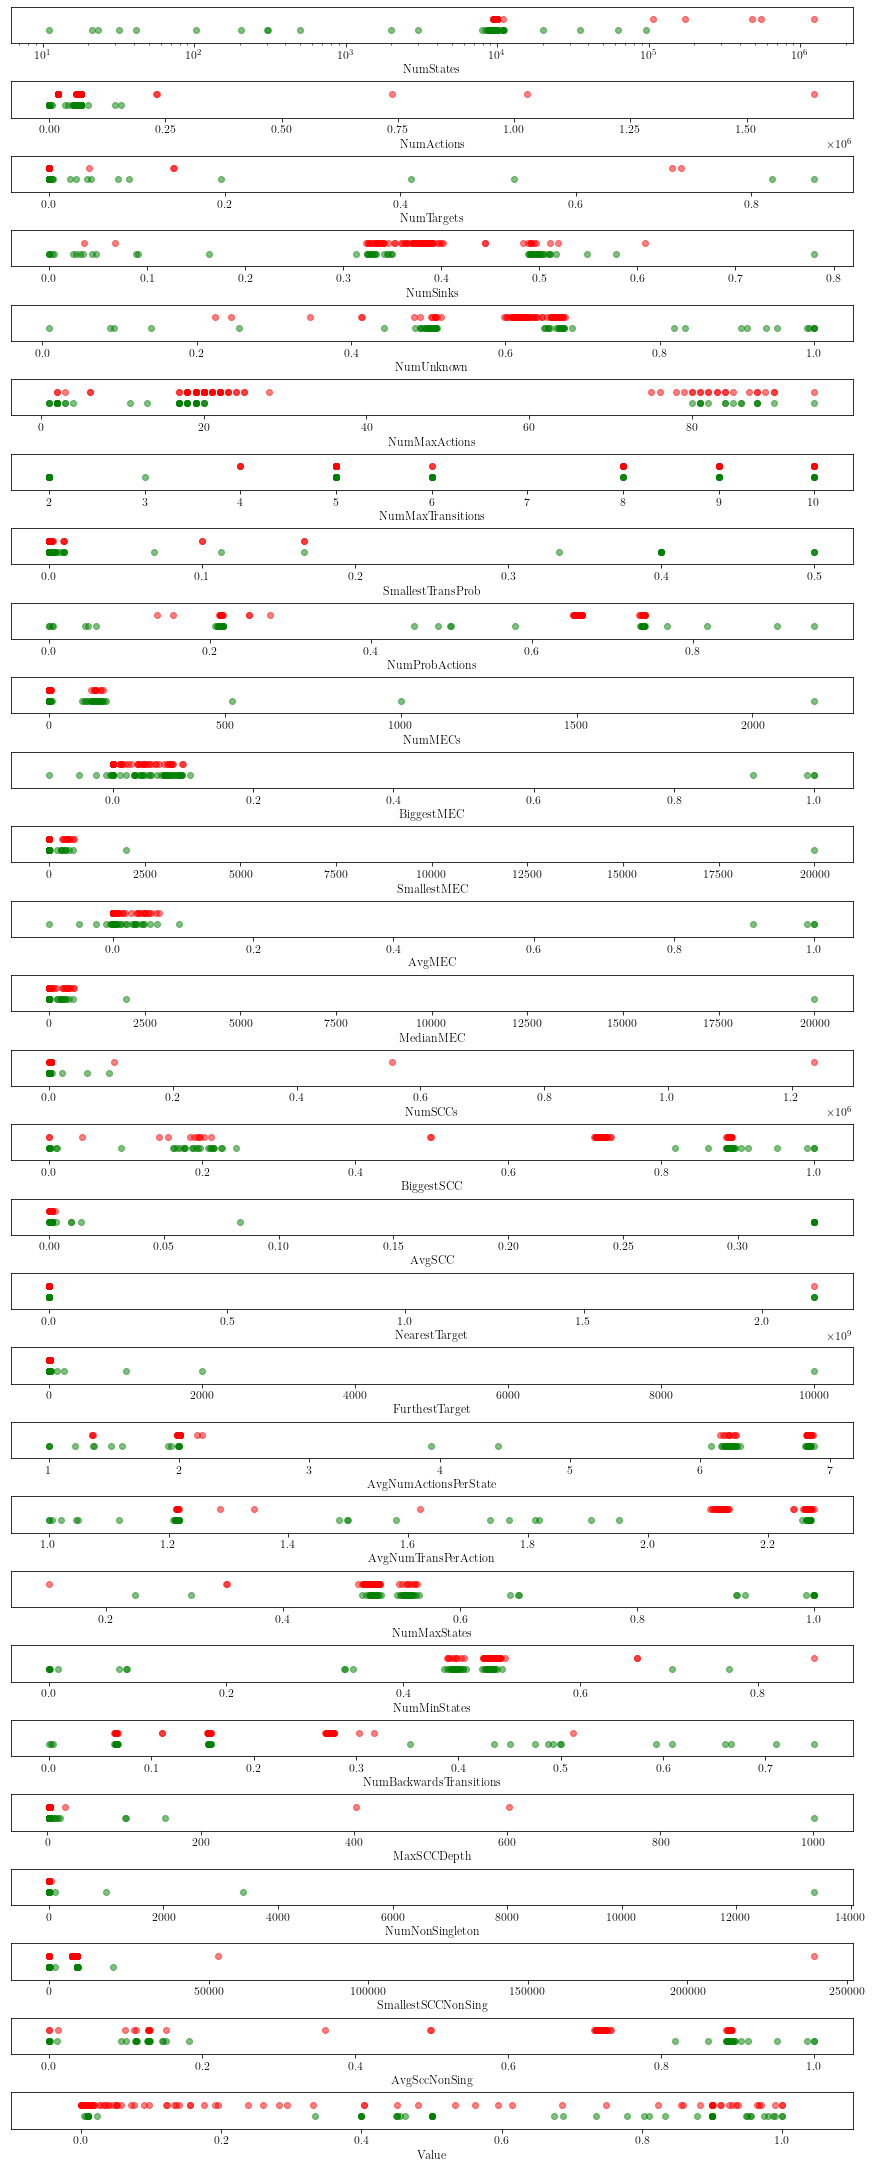

In [4326]:

print("RED: EVENT A (usually Conf_A is WORSE than Conf_B), GREEN: Counter Event")
interesting_props = property_keys + ["values_WP_P3"]


oneDimensionPropertyScatterPlot(interesting_props, confA_worse_than_confB, counter_event)

In [3166]:
#Histograms
# PyPlot settings Settings
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}


def HistogramPlot(property_keys, a_indices, b_indices):
    entries_per_column = 1
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,30), constrained_layout = True)
    row = 0
    column = 0
    
    for property_key in property_keys:
        data_for_a = []
        data_for_b = []
        for i in a_indices:
            data_for_a.append(data[property_key][i])
        for i in b_indices:
            data_for_b.append(data[property_key][i])
            
        minimal_value = 0    
        # Use log-scale for data with high numbers
        WHEN_TO_USE_LOG_SCALE = [
            property_key == "NumStates",
            #np.max(data[property_key]) > 1e4
        ]
        if (np.any(WHEN_TO_USE_LOG_SCALE)):
            axs[row].set_xscale('log')
            minimal_value = 1e-6
            data_for_a = [max(x, minimal_value) for x in data_for_a]
            data_for_b = [max(x, minimal_value) for x in data_for_b]
            
        #ALPHA_A = 5/len(data_for_a)
        ALPHA_A = 0.5
        
        
        #ALPHA_B = 5/len(data_for_b)
        ALPHA_B = 0.5
        
        axs[row].hist(data_for_a, alpha = 0.5, facecolor = 'red')
        axs[row].hist(data_for_b, alpha = 0.5, facecolor = 'green')
        axs[row].scatter([data_for_a[0], data_for_a[0]], [-3, 3], alpha=0.001) # Set Axis limits
        axs[row].set_xlabel(property_key)
        axs[row].get_yaxis().set_ticks([])
        
        if (property_key == "values_WP_P3"):
            axs[row].set_xlim([-0.1,1.1])
            axs[row].set_xlabel("Value")
            
        
        row+=1
    plt.savefig('1DScatter.pdf')

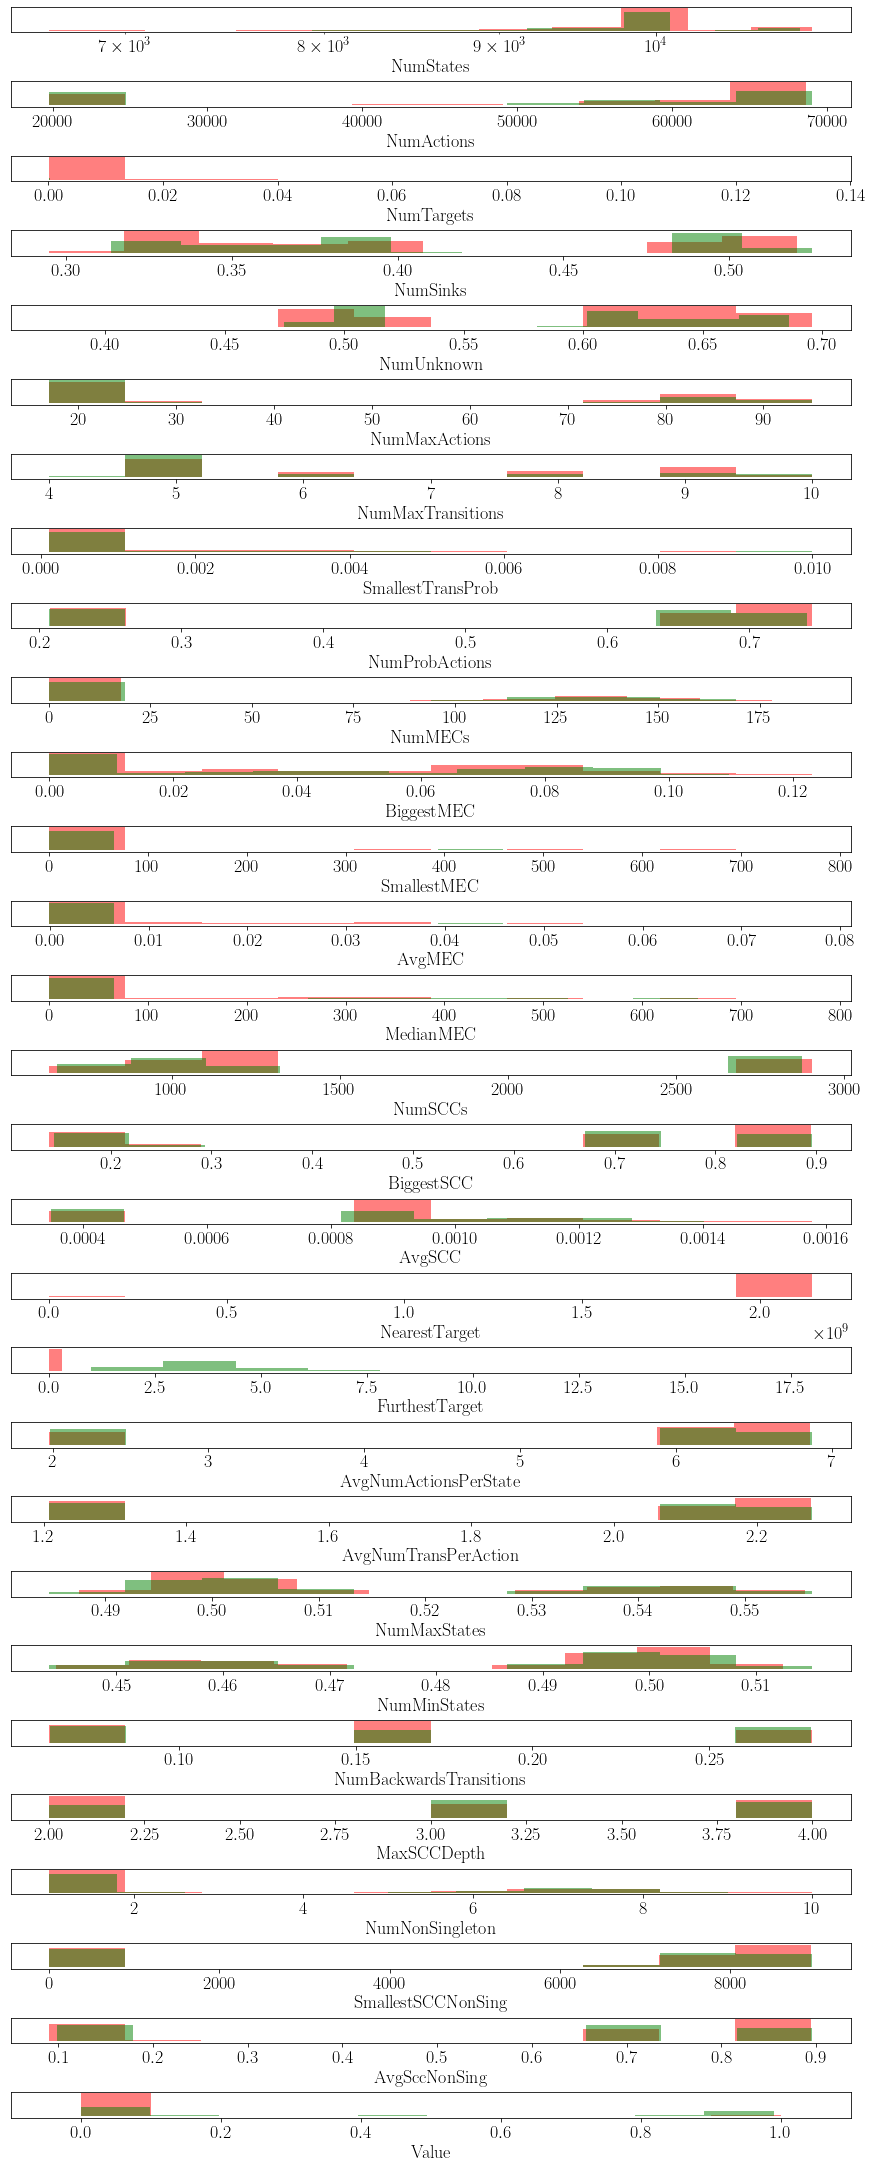

In [3167]:
interesting_props = property_keys + ["values_WP_P3"]


HistogramPlot(interesting_props, wp_no_iters, wp_mul_iters)

### Interpret the graph

In [3157]:
print(len(model_names))
print(len(data["NumStates"]))

284
284


In [ ]:
#Get names of models above certain threshold

absolute_allowed_timedifference_in_seconds = 2
relative_allowed_timedifference = 0.1 # 0.1 -> 10% allowed difference
USE_RELATIVE_ERROR = True

confs_to_compare = config_keys
#confs_to_compare = ["OVI_1", "OVI_100"]

fastest_solver = dict()
for index in range(len(data["NumStates"])):
    model = model_names[index]
    print("MODEL: %s" % model)
    fastest_solver[model] = [10000000, []]
    for key in confs_to_compare:
        soln_time = data[key][index]
        print("Conf %s soln time %f" % (key, soln_time))
        if (soln_time != PENTALY_FOR_NOT_FINISHING):
            #print("This is better than NOT FINISHING")
            if (fastest_solver[model][0] > soln_time):
                # Check which of the currently saved models are in the allowed precision
                new_soln_time = fastest_solver[model][0]
                fastest_solvers_for_model = [key]
                for old_key in fastest_solver[model][1]:
                    old_soln_time = data[old_key][index]
                    # Do comparison
                    include_old_key = False
                    
                    USE_RELATIVE_ERROR = new_soln_time > 10
                    
                    if (USE_RELATIVE_ERROR):
                        include_old_key = (1.0 - relative_allowed_timedifference) * new_soln_time <= old_soln_time
                    else:
                        include_old_key = abs(new_soln_time - old_soln_time) <= absolute_allowed_timedifference_in_seconds
                    
                    if (include_old_key):
                        fastest_solvers_for_model.append(old_key)
                
                fastest_solver[model] = [soln_time, fastest_solvers_for_model]
                
            elif (fastest_solver[model][0] == soln_time):
                fastest_solver[model][1].append(key)

In [ ]:
bestSolvers = dict()
for config_key in confs_to_compare:
    bestSolvers[config_key] = 0

for index in range(len(data["NumStates"])):
    model_name = model_names[index]
    for config_key in fastest_solver[model_name][1]:
        bestSolvers[config_key]+=1

for config_key in confs_to_compare:
    print("Config %s was the best solution method %d / %d times" % (config_key, bestSolvers[config_key], len(table_times)))

In [1041]:
#If you want to know which Models a Conf won, use this:
check_conf = "TBBVI_100"
explicit = True

for index in range(len(data["NumStates"])):
    model = model_names[index]
    if check_conf in fastest_solver[model][1]:
        print(model)
        if explicit:
            props = findModelWithNameInTable(table_properties, model)
            #print(props["NumSCCs"])
            for prop in props:
                print(prop," : ", props[prop])

KeyError: 'simple_1000000_1_SCC'

# Do classic Data Mining stuff

## Heatmaps

In [ ]:
excluded_features = [
    #"NumTargets",
    #"SmallestTransProb"
]

correlation_dict = dict(data)

for feature in excluded_features:
    del correlation_dict[feature]

size = len(analysis_keys) - len(excluded_features) + len(config_keys)
print(size)

In [314]:
#Linear Correlation
fig = plt.figure(figsize=(size,size))

df = pd.DataFrame(correlation_dict,columns=correlation_dict.keys())

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


NameError: name 'size' is not defined

## Scatter Plots

In [3115]:
#Scatterplot
def createScatterPlotForOneProperty(property_key):
    entries_per_column = int(math.sqrt(len(config_keys))+1)
    entries_per_row = entries_per_column
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(16,16), sharey=True)
    row = 0
    column = 0
    for key in config_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].scatter(data[property_key], data[key])
        axs[row, column].set_xlabel(property_key),
        axs[row, column].set_ylabel(key)
        column+=1

def createScatterPlotForOneConfig(property_keys):
    entries_per_column = 1    
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            axs[row].scatter(data[property_key], data[key])
            axs[row].set_xlabel(property_key),
            axs[row].set_ylabel(key)
            column+=1

def createScatterPlotForMultipleProperties(property_keys, algo_keys, y_limit = float('inf')):
    entries_per_column = len(algo_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,30), constrained_layout=True, sharey=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in algo_keys:
            
            ALPHA = 0.2
            #ALPHA = 10/len(data[key])
            
            data_plotted = [min(x, y_limit) for x in data[key]]         
            if (column == entries_per_column):
                row += 1
                column = 0
            if (USE_LABELS):
                axs[row, column].scatter(data[property_key], data_plotted, alpha=ALPHA, c=pandas_labels.map(coloring))
            else:
                axs[row, column].scatter(data[property_key], data_plotted, alpha=ALPHA)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(label_mapping[key])
            column+=1

def createHistPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            sn.histplot(x = data[property_key], y =  data[config_key], cbar=True)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

In [3116]:
print(property_keys)

['NumStates', 'NumActions', 'NumTargets', 'NumSinks', 'NumUnknown', 'NumMaxActions', 'NumMaxTransitions', 'SmallestTransProb', 'NumProbActions', 'NumMECs', 'BiggestMEC', 'SmallestMEC', 'AvgMEC', 'MedianMEC', 'NumSCCs', 'BiggestSCC', 'AvgSCC', 'NearestTarget', 'FurthestTarget', 'AvgNumActionsPerState', 'AvgNumTransPerAction', 'NumMaxStates', 'NumMinStates', 'NumBackwardsTransitions', 'MaxSCCDepth', 'NumNonSingleton', 'SmallestSCCNonSing', 'AvgSccNonSing']


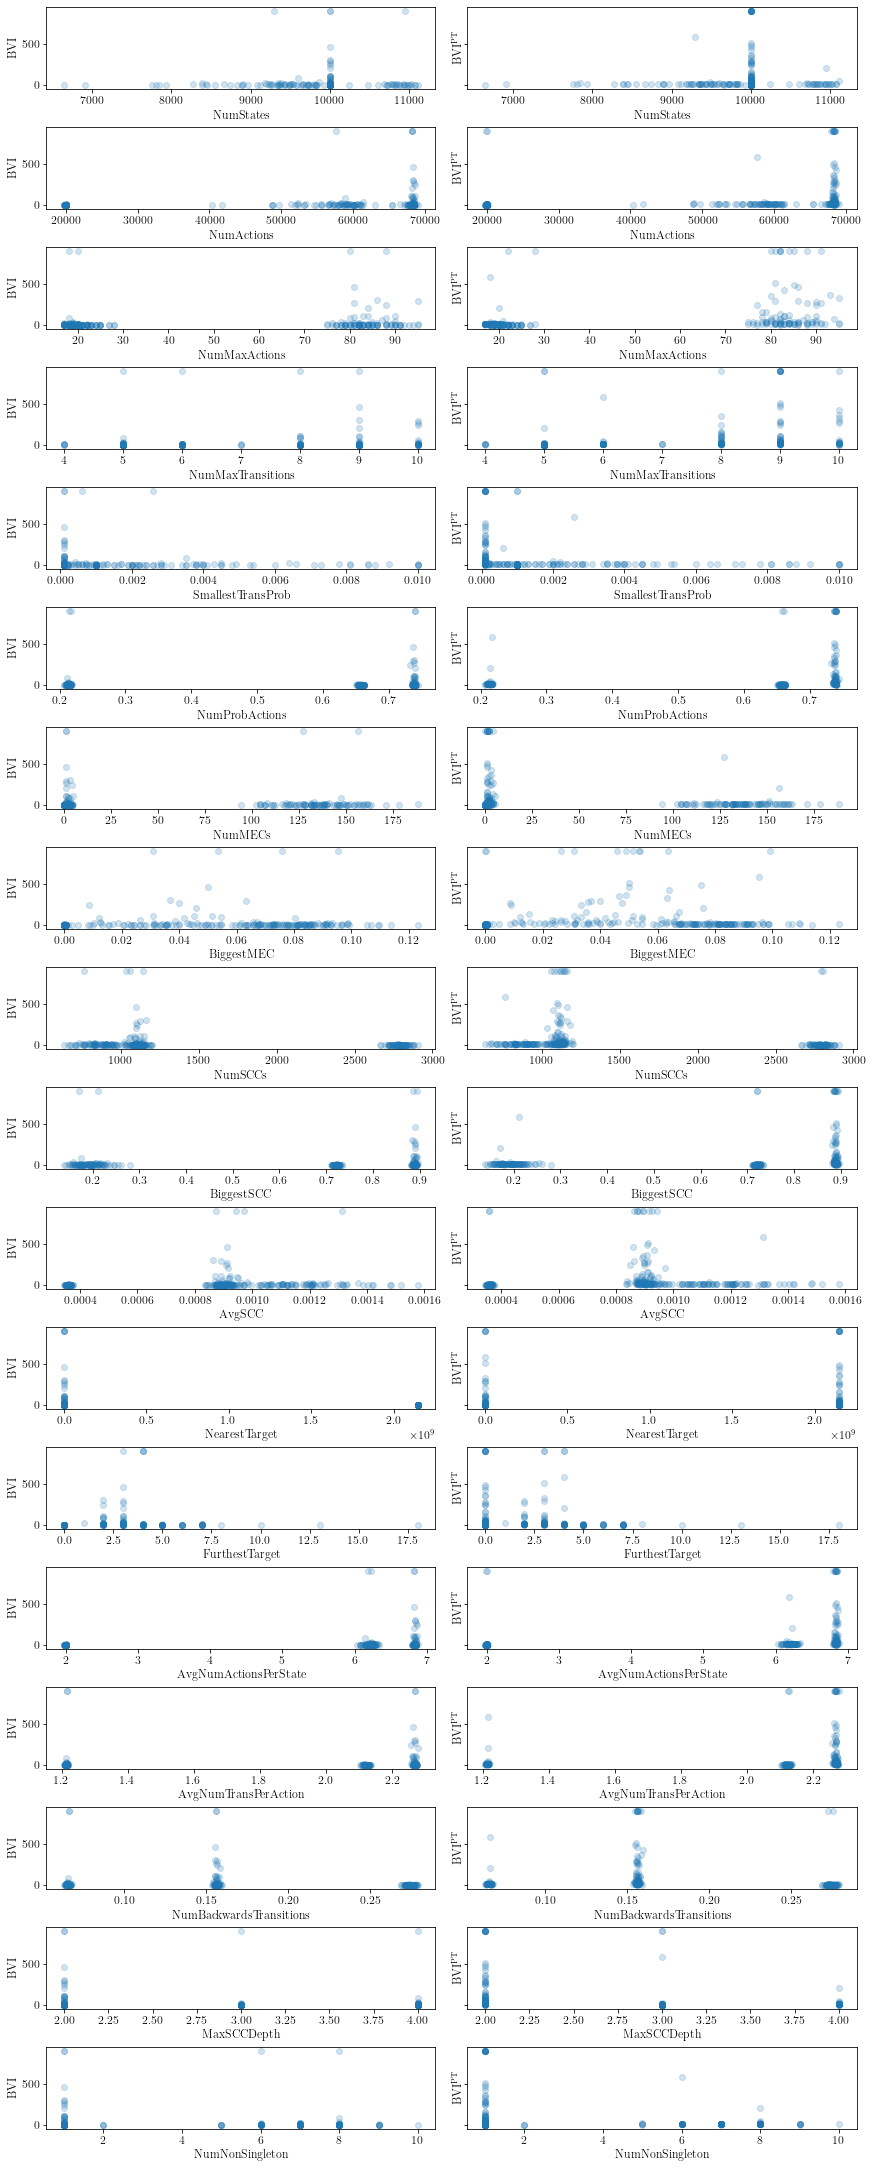

In [3117]:
if(USE_LABELS):
    print(coloring)

createScatterPlotForMultipleProperties(
    [
    "NumStates",
    "NumActions",
    #"NumTargets",
    #"NumSinks",
    #"NumUnknown",
    "NumMaxActions",
    "NumMaxTransitions",
    "SmallestTransProb",
    "NumProbActions",
    "NumMECs",
    "BiggestMEC",
    #"SmallestMEC",
    #"AvgMEC",
    #"MedianMEC",
    "NumSCCs",
    "BiggestSCC",
    "AvgSCC",
    "NearestTarget",
    "FurthestTarget",
    "AvgNumActionsPerState",
    #"AvgNumTransPerState",
    "AvgNumTransPerAction",
    #"NumMaxStates",
    #"NumMinStates",
    "NumBackwardsTransitions",
    "MaxSCCDepth",
    "NumNonSingleton"
    ],
    ["BVI", "TOP_BVI"]
)

In [762]:
#createHistPlotForMultipleProperties(["BiggestMEC", "NumUnknown", "NumMECs", "NumStates", "NumMaxActions", "NumProbActions"])

## Chi-square Tests: Are two features independent?

In [ ]:
def bin_estimate(length):
    return int(1+math.log2(length))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


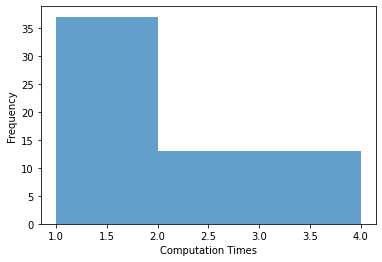

In [2176]:
#Histograms
#Each Bin should contain at least (recommended) 13 entries
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
prop = "NumUnknown"

x_set = [1]*37 + [2]*13 + [3]*13
y_set = [100]*37 + [300]*13 + [500]*13
print(x_set)
x_bins = (1, 2, 3, 4)#bin_estimate(len(data_set))
y_bins = (100, 300, 500, 700)

x_hist_gram = np.histogram(x_set, bins=x_bins)
y_hist_gram = np.histogram(y_set, bins=(100, 200, 300))
n, bins, patches = plt.hist(x=x_set, bins=x_bins, alpha = 0.7)
plt.xlabel('Computation Times')
plt.ylabel('Frequency')

plt.show()


[[37.  0.  0.]
 [ 0. 13.  0.]
 [ 0.  0. 13.]]


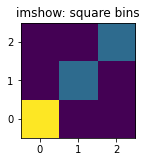

In [2177]:

H, xedges, yedges = np.histogram2d(x_set, y_set, bins=(x_bins, y_bins))
print(H)
# Histogram does not follow Cartesian convention (see Notes),

# therefore transpose H for visualization purposes.

H = H.T
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(131, title='imshow: square bins')

plt.imshow(H, interpolation='nearest', origin='lower')

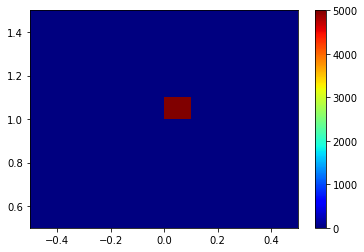

In [2178]:
# create data
x = [0]*5000#np.random.normal(size=5000)
y = [1]*5000#np.random.normal(size=5000)
 
# Big bins
H, x_edges, y_edges, img = plt.hist2d(x, y, bins=(10,10), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# Small bins
#plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.jet)
#plt.show()
 
# If you do not set the same values for X and Y, the bins won't be a square!
#plt.hist2d(x, y, bins=(300, 30), cmap=plt.cm.jet)
#plt.show()

In [2179]:
#print(H)
ChiSq, p = stats.chisquare(np.ndarray.flatten(H))
print(ChiSq)
print(p)

495000.0
0.0


#### Ensure VI is not wrong

In [2180]:
vi = "VI"
ref = "BVI"

for i in range(len(data[vi])):
    

IndentationError: expected an indented block (2813565325.py, line 5)

### OII Stuff

In [ ]:
numTimesHappened = dict()
events  = ["UPPER_DONE", "LOWER_DONE", "BVI_CRITERION", "TOTAL_UPPER", "TOTAL_LOWER"]
for conf in ["D_WP_OII"]:
    numTimesHappened[conf] = dict()
    for event_name in events:
        numTimesHappened[conf][event_name] = 0
    conf_path = PATH_TO_CSV_FOLDER+conf+"/"
    for model_file_name in os.listdir(conf_path):
        with open(conf_path+model_file_name, newline='\n') as conf_model_run:
            for line in conf_model_run:
                if ("The induced bound from L was an upper bound" in line):
                    #print("IN CONF %s AND FILE \n%s: " % (conf, model_file_name))
                    #print(line)
                    numTimesHappened[conf]["LOWER_DONE"]+=1
                elif ("The induced bound from U was a lower bound" in line):
                    numTimesHappened[conf]["UPPER_DONE"]+=1
                elif ("Upper and Lower bounds are eps-close -> BVI iteration criterion met" in line):
                    numTimesHappened[conf]["BVI_CRITERION"]+=1
                elif ("Total Lower Verification Iterations: " in line):
                    numTimesHappened[conf]["TOTAL_LOWER"]+=int(line.replace("Total Lower Verification Iterations: ", ""))
                elif ("Total Upper Verification Iterations: " in line):
                    numTimesHappened[conf]["TOTAL_UPPER"]+=int(line.replace("Total Upper Verification Iterations: ", ""))
                    
                    
for key in numTimesHappened.keys():
    print("%s: %s" % (key, str(numTimesHappened[key])))

### Load Prism Files you are interested in

In [ ]:
## Print Log File in case you wanna know
log_name = "RANDOM_Size_10002_MinAct_10_Type-scc_MinTransProb_0.0001_Model_69.log"

for conf in ["T_LP_SI"]:
    conf_path = PATH_TO_CSV_FOLDER+conf+"/"
    for model_file_name in os.listdir(conf_path):
        with open(conf_path+model_file_name, newline='\n') as conf_model_run:
            for line in conf_model_run:
                if (model_file_name == log_name):
                    print(line)

In [321]:
print(LOAD_PATHS)RANDOM_Size_10002_MinAct_10_Type-scc_MinTransProb_0.0001_Model_6969

['../thesis-scripts/randomRandomThesis/', '../thesis-scripts/realModels/', '../thesis-scripts/handcraftedModels/', '../thesis-scripts/randomRandom10Act/', '../thesis-scripts/randomSCCFixed_2/', '../thesis-scripts/bigRealModels/', '../thesis-scripts/bigRealModelsNoPrecomp/', '../thesis-scripts/bigConfModels/', '../thesis-scripts/bigConfModelsNoPre/']


In [2834]:
## Save prism File in visualization Folder to copy it easily to your local partition
print(PATH_TO_CSV_FOLDER)
prism_file_name

for path in LOAD_PATHS:
    

path_to_prism_files = "../random-generated-models/tacasRandomConnectedModels/"
prism_file_name = "RANDOM_Size_1002_MinTransProb_0.0001_Model_12"

with open(path_to_prism_files+prism_file_name+'.prism', newline='\n') as prismFile:
    s = prismFile.read()
    df=pd.DataFrame([s])
    with open("CurrentInterestingModel.prism", "w") as newPrismFile:
        newPrismFile.write(s)

../sasha-tacas-scripts/tacasRandomConnected15Min/


In [ ]:
model_name = "RANDOM_Size_10002_Type-tree_Model_8.log"

index = indexOfModelName(model_name)

data["OII"][index]

In [ ]:
for i in event_a:
    print("BVI: %f, OVI: %f, OII: %f" % (data["BVI"][i], data["OVI"][i], data["OII"][i]))

# OVI iterations

In [1460]:
data.keys()

dict_keys(['NumStates', 'NumActions', 'NumTargets', 'NumSinks', 'NumUnknown', 'NumMaxActions', 'NumMaxTransitions', 'SmallestTransProb', 'NumProbActions', 'NumMECs', 'BiggestMEC', 'SmallestMEC', 'AvgMEC', 'MedianMEC', 'NumSCCs', 'BiggestSCC', 'AvgSCC', 'NearestTarget', 'FurthestTarget', 'AvgNumActionsPerState', 'AvgNumTransPerAction', 'NumMaxStates', 'NumMinStates', 'NumBackwardsTransitions', 'MaxSCCDepth', 'NumNonSingleton', 'SmallestSCCNonSing', 'AvgSccNonSing', 'OVI', 'WP_P3', 'values_OVI', 'values_WP_P3', 'iters_OVI', 'iters_WP_P3', 'ovi_itersG_OVI_Conf', 'ovi_itersG_OVI_Verification Time', 'ovi_itersG_OVI_Number Of Verif. Phases', 'ovi_itersG_OVI_Iterations in Verif Phase', 'ovi_itersG_OVI_NumAborted', 'ovi_itersG_OVI_NumInduceLowerBound', 'ovi_itersG_OVI_NumFailedVerif', 'ovi_itersOPT_OVI_Conf', 'ovi_itersOPT_OVI_Verification Time', 'ovi_itersOPT_OVI_Number Of Verif. Phases', 'ovi_itersOPT_OVI_Iterations in Verif Phase', 'ovi_itersOPT_OVI_NumAborted', 'ovi_itersOPT_OVI_NumInduceL

In [1461]:
iters_data = {}
for key in data.keys():
    if 'ovi_itersOVI_' in key:
        k = key.replace('ovi_itersOVI_', '')
        iters_data[k] = data[key]

In [1462]:
df = pd.DataFrame(iters_data)
for key in iters_data.keys():
    df[key] = df[key].astype(int)

In [1463]:
df

,Conf,Verification Time,Number Of Verif. Phases,Iterations in Verif Phase,NumAborted,NumInduceLowerBound,NumFailedVerif
0,3,101,2,50,1,1,0
1,3,69,3,32,2,2,0
2,3,377,2,38,1,1,0
3,3,206,2,44,1,1,0
4,3,0,1,4,0,0,0
5,3,0,1,2,0,0,0
6,3,0,1,22,0,0,0
7,3,0,1,3,0,0,0
8,3,3,1,3,0,0,0
9,3,0,1,1,0,0,0


In [1464]:
df.insert(loc=0,
          column='Model',
          value=model_names)

In [1465]:
df.insert(loc=1,
          column='NumStates',
          value=data['NumStates'])
df['NumStates'] = df['NumStates'].astype(int)

In [1466]:
df = df.drop(labels='Conf', axis=1)

In [1467]:
df

,Model,NumStates,Verification Time,Number Of Verif. Phases,Iterations in Verif Phase,NumAborted,NumInduceLowerBound,NumFailedVerif
0,AV10_10_2,106524.0,101,2,50,1,1,0
1,AV10_10_3,106524.0,69,3,32,2,2,0
2,AV15_15_2,480464.0,377,2,38,1,1,0
3,AV15_15_3,480464.0,206,2,44,1,1,0
4,adt,305.0,0,1,4,0,0,0
5,charlton1,502.0,0,1,2,0,0,0
6,charlton2,502.0,0,1,22,0,0,0
7,cloud5,8842.0,0,1,3,0,0,0
8,cloud6,34954.0,3,1,3,0,0,0
9,coins,19.0,0,1,1,0,0,0


In [1468]:
abortions = df[df['NumAborted']>0]
abortions

,Model,NumStates,Verification Time,Number Of Verif. Phases,Iterations in Verif Phase,NumAborted,NumInduceLowerBound,NumFailedVerif
0,AV10_10_2,106524.0,101,2,50,1,1,0
1,AV10_10_3,106524.0,69,3,32,2,2,0
2,AV15_15_2,480464.0,377,2,38,1,1,0
3,AV15_15_3,480464.0,206,2,44,1,1,0
10,dice100,554395.0,155,2,127,1,1,0
11,dice150,1236595.0,222,2,295,1,1,0
17,two_investors,172240.0,23,2,82,1,1,0


In [1447]:
len(abortions) / len(model_names)

0.3888888888888889

In [1622]:
model_names

['simple_10000000_1_SCC',
 'simple_10000000_5_SCC',
 'simple_1000000_1_SCC',
 'simple_1000000_5_SCC',
 'simple_100000_1_SCC',
 'simple_100000_5_SCC',
 'simple_2000000_1_SCC',
 'simple_2000000_5_SCC',
 'simple_3000000_1_SCC',
 'simple_3000000_5_SCC',
 'simple_4000000_1_SCC',
 'simple_4000000_5_SCC',
 'simple_5000000_1_SCC',
 'simple_5000000_5_SCC',
 'simple_500000_1_SCC',
 'simple_500000_5_SCC',
 'simple_50000_1_SCC',
 'simple_50000_5_SCC']

In [1728]:
data['Unknown\%'] = np.around(data['Unknown\%'], 4)
data['ProbActions\%'] = np.around(data['ProbActions\%'], 4)

In [1729]:
data['Unknown\%']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [89]:
data_df = pd.DataFrame(data)

In [48]:
import os

In [90]:
data_df["Model"] = model_names

In [98]:
data_df[data_df["Model"].str.contains("hm")][["Model", "BVI", "LP_SI"]]

,Model,BVI,LP_SI
61,hm_10,0.112,0.039
62,hm_20,147.363,0.081
63,hm_5,0.026,0.066


In [46]:
evaled_models = list(evaluation_df["Model"])

In [47]:
evaled_models

['simple_100000_5_SCC',
 'BigMec_1e3',
 'BigMec_1e4',
 'ManyMECs_1e3',
 'hm_20',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_11',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_12',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_13',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_22',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_29',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_30',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_34',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_35',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_38',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_41',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_61',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_68',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_69',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_74',
 'RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_82',
 'RA

In [50]:
LOAD_PATHS

['../thesis-scripts/realModels_2/',
 '../thesis-scripts/realModels/',
 '../thesis-scripts/handcraftedModels/',
 '../thesis-scripts/randomRandomThesis/',
 '../thesis-scripts/randomRandom10Act/',
 '../thesis-scripts/randomSCCFixed_2/',
 '../thesis-scripts/bigConfModels/']

In [51]:
x = [
    "../random-generated-models/newScc/",
    "../random-generated-models/sccFixed_2/",
]

In [54]:
for p in x:
    for m in evaled_models:
        n = os.path.join(p,m+".prism")
        if (os.path.exists(n)):
            print('Great! Exist: ',n)
            

Great! Exist:  ../random-generated-models/newScc/RANDOM_Size_10000_MinAct_10_MinTransProb_0.0001_Model_11.prism
Great! Exist:  ../random-generated-models/sccFixed_2/RANDOM_Size_10002_MinAct_10_Type-scc_MinTransProb_0.0001_Model_1.prism
